# Moment models fine-tune analysis | Mask test
> This notebook is the pre-analysis of moment models to select the cases used in the paper.

# RECORDATORIO 
1) Conseguir que compilen de nuevo
2) Enmascarar también en evaluación, no solo en training, majaretilla...

In [3]:
# Input parameters
model_patch_size = 8
verbose          = 0
reset_kernel     = False

In [4]:
#! pip install --no-deps ydata_profiling
#! pip install --no-deps dacite
#! pip install --no-deps multimethod
#! pip install --no-deps visions
#! pip install --no-deps wordcloud
#! pip install --no-deps imagehash
#! pip install --no-deps htmlmin

In [5]:
# Imports
from dvats.all import *
from tsai.data.preparation import SlidingWindow
from fastcore.all import *
import wandb
wandb_api = wandb.Api()
from yaml import load, FullLoader
import dvats.utils as ut
from dvats.imports import beep
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import ydata_profiling as ydp
import seaborn as sns

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcWriteOptions size changed, may indicate binary incompatibility. Expected 72 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.Tensor size changed, may indicate binary incompatibility. Expected 64 from C header, got 80 from PyObject
<froze


Octave is ready <oct2py.core.Oct2Py object at 0x7f7b640ffd30>

















In [6]:
import torch
#torch.cuda.set_device(0)
torch.cuda.set_device(1)

In [7]:
from fastai.losses import MSELossFlat
from dvats.encoder import MAELossFlat, EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE
import dvats.config as cfg_
import gc
import os

### Setting up Weight & Biases information

In [8]:
# User and project
entity = os.environ.get("WANDB_ENTITY")
project = os.environ.get("WANDB_PROJECT")
folder = entity+'/'+project+'/'

# Dataset
dataset = 'gtrends_kohls'
dataset_version = 'v2'
enc_artifact_dataset = folder + dataset + ':' + dataset_version

# Models
model_family = 'zeroshot-moment'
task = 'embedding'
enc_artifact_small_name = folder + model_family + '-small-' + task + ':v0'
enc_artifact_base_name  =  folder + model_family + '-base-' + task + ':v0'
enc_artifact_large_name = folder + model_family + '-large-' + task + ':v0'

In [9]:
enc_artifact_small_name

'mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0'

### Download dataset

In [10]:
print("Getting dataset artifact: ", enc_artifact_dataset)
df_artifact = wandb_api.artifact(enc_artifact_dataset, type = 'dataset')

Getting dataset artifact:  mi-santamaria/deepvats/gtrends_kohls:v2


In [11]:
print(df_artifact.name)
df = df_artifact.to_df()
display(df.head())
df.shape

gtrends_kohls:v2


wandb:   1 of 1 files downloaded.  


volume
2004-01-01  0.010417
2004-01-08  0.010417
2004-01-15  0.010417
2004-01-22  0.000000
2004-01-29  0.000000

(440, 1)

### Encoder Input

In [12]:
#enc_input, _ = SlidingWindow(window_len=17, stride=2, get_y=[])(df)
#enc_input.shape
enc_input = df

### Functions

In [10]:
def count_parameters(model):
    #return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def greater_than(lst, val):
    vals = []
    for x in lst:
        try:
            x = int(x)
            if (x > val): 
                vals.append(x)
        except:
            continue
    return vals
    #return [ x for x in lst if isinstance(x, int) and x > val]

In [11]:
def plot_with_multiple_secondary_y(df, primary_vars, secondary_vars, figsize=(12, 6)):
    """
    Plots multiple variables with different scales on primary and secondary y-axes.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - primary_vars (list): Variables to plot on the primary y-axis.
    - secondary_vars (list): Variables to plot on the secondary y-axis.
    - figsize (tuple): Size of the figure.

    Returns:
    - None: Displays the plot.
    """
    ax = df[primary_vars + secondary_vars].plot(
        secondary_y=secondary_vars, figsize=figsize
    )
    ax.set_title("Variables with Primary and Secondary Axes")
    plt.show()

In [12]:
def plot_correlation(profile, figsize=(8, 6)):
    correlation_matrix = profile.corr()
    # Crear el heatmap con seaborn
    plt.figure(figsize = figsize)  # Ajusta el tamaño si es necesario
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix")
    plt.show()

### Common Fine-tune args

In [13]:
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

In [14]:
print(config['batch_size'])
print(config['r'])
print(config['analysis_mode'])

16
0.4
online


In [15]:
config['r'] = 1e-3 #1e-6
config['r']

0.001

In [16]:
config['norm_use_single_batch']

False

In [17]:
common_args = {
    "X": df,
    "stride": 1,
    "batch_size": config['batch_size'],
    "cpu": False,
    "to_numpy": False,
    "time_flag": True,
    "n_windows": None,
    "n_windows_percent": None,
    "shot": True,
    "eval_pre": True,
    "eval_post": True,
    "lr": config['r'], #use enc_run lr,
    "lr_scheduler_flag": True, # False
    "lr_scheduler_name": "cosine_with_restarts",
    "lr_scheduler_num_warmup_steps": 100, # None
    "window_sizes": [12],
    "full_dataset": True,
    "window_sizes_offset": 0.05,
    "windows_min_distance": 0, #int(np.ceil(1.5*enc_input.shape[0]/100)),
    "print_to_path": True,
    "print_both": False,
    "print_path": "./logs.txt",
    "print_mode": "a",
    "use_moment_masks": True,
    "mask_stateful": config['mask_stateful'],
    "mask_future": config['mask_future'],
    "mask_sync": config['mask_sync'],
    "analysis_mode": config['analysis_mode'],
    "use_wandb": config['use_wandb'],
    "norm_by_sample": config['norm_by_sample'],
    "norm_use_single_batch": config['norm_use_single_batch'],
    "show_plot": True,
    "metrics": [EvalMSE, EvalRMSE, EvalMAE, EvalSMAPE],
    "metrics_args": [{'squared': False}, {'squared': True}, {}, {}],
    "metrics_names":["mse", "rmse", "mae", "smape"],
    "metrics_dict": None,
    "criterion": torch.nn.MSELoss(),
    "mix_windows": True
}

In [18]:
common_args["windows_min_distance"]

0

### Cases execution function

In [19]:
from momentfm.utils.masking import Masking 

In [20]:
def cases_loop(
    model, 
    n_epochs_list, 
    dataset_percents, 
    masked_percents, 
    n_sizes_list, 
    summarized = True, 
    do_beep = True, 
    verbose = 1,
    save = True,
    file_errors = "",
    file_results = ""
):
    mssg = ut.Mssg(verbose = verbose, level = -1)
    result_columns = [
        'model_size','n_epochs','dataset_percent','masked_percent','n_windows', 
        'time',
        'first_train_loss','first_mse','first_rmse','first_mae','first_smape', 
        'last_train_loss','last_mse','last_rmse','last_mae','last_smape'
    ]
    result_columns = result_columns if summarized else result_columns + ['losses','eval_results_pre','eval_results_post']
    results = pd.DataFrame(columns = result_columns)
    
    errors = pd.DataFrame(
        columns = [
            'model_size',
            'n_epochs',
            'dataset_percent',
            'masked_percent',
            'n_windows',
            'windows',
            'error'
        ]
    )
    model_backup = deepcopy(model)
    i = 0
    for n_epochs in n_epochs_list:
        for dataset_percent in dataset_percents:
            print(dataset_percent)
            for masked_percent in masked_percents:
                model.mask_generator = Masking(mask_ratio = masked_percent)
                for sizes in n_sizes_list:
                    print(f"--> epoch {n_epochs}, dataset_percent {dataset_percent}, mask {masked_percent}")
                    redmssg = f" sizes {sizes}"
                    redmssg = f"\033[91m{redmssg}\033[0m"
                    print(redmssg)

                    print(f"Cuda memmory allocated: {torch.cuda.memory_allocated()}")
                    model_case = deepcopy(model_backup)
                    case = {
                            'model_size': "small",
                            'n_epochs': n_epochs,
                            'dataset_percent': dataset_percent,
                            'masked_percent': masked_percent,
                            'n_windows': sizes,
                            'windows': None
                           }
                    result_dict = deepcopy(case)
                    error_dict = deepcopy(case)
                    error = False
                    print(1-dataset_percent)
                    torch.cuda.synchronize()
                    result = fine_tune(
                        enc_learn           = model_case,
                        window_mask_percent = masked_percent,
                        training_percent    = dataset_percent,
                        validation_percent  = 0.3,
                        num_epochs          = n_epochs,
                        n_window_sizes      = sizes,
                        verbose             = verbose,
                        register_errors     = True,
                        save_best_or_last   = True, # only available for moment,
                        #force_best_lr       = True,
                        **common_args    
                    )
                    common_args['print_mode']='a'

                    default_error = pd.DataFrame([{
                        'model_size': case['model_size'], 
                        'n_epochs': case['n_epochs'],
                        'dataset_percent': case['dataset_percent'],
                        'masked_percent': case['masked_percent'],
                        'n_windows': sizes,
                        'windows': "Unknown",
                        'error': 'Non registered error',
                        'window': "Unknown"
                    }])

                    try:
                        print("---- Returned internal errors ---")
                        internal_errors = result[10]
                        
                    except:
                        internal_errors = default_error
            
                    print("Check:", result[0])
                    if len(result[0]) > 0:
                    
                        result_dict.update({
                            'time'             : result[4],
                            'windows'          : result[8].cpu() if isinstance(result[8], torch.Tensor) else result[8],
                            'first_train_loss' : result[0][0][0].cpu().item() if torch.is_tensor(result[0][0][0]) else result[0][0][0],
                            'last_train_loss'  : result[0][-1][-1].cpu().item() if torch.is_tensor(result[0][-1][-1]) else result[0][-1][-1],
                            'best_epochs'       : result[9],
                            'train_losses'      : result[0][0],
                            'eval_pre'          : result[1],
                            'eval_post'         : result[2],
                            'full_result'       : result
                        })
                        if result[1] == {}:
                            result_dict.update({
                                'first_eval_loss'  : np.nan,
                                'first_mse'        : np.nan,
                                'first_rmse'       : np.nan,
                                'first_mae'        : np.nan
                            })
                        else:
                            print("N windows: ", len(result[8]))
                            print("Loss: ", result[1]['loss'])
                            result_dict.update({
                                'first_eval_loss'  : result[1]['loss'][-1].cpu().item() if torch.is_tensor(result[1]['loss']) else result[1]['loss'][-1],
                                'first_mse'        : result[1]['mse'][-1].cpu().item() if torch.is_tensor(result[1]['mse']) else result[1]['mse'][-1],    
                                'first_rmse'       : result[1]['rmse'][-1].cpu().item() if torch.is_tensor(result[1]['rmse']) else result[1]['rmse'][-1],
                                'first_mae'        : result[1]['mae'][-1].cpu().item() if torch.is_tensor(result[1]['mae']) else result[1]['mae'][-1],                                
                                'first_smape'      : result[1]['smape'].cpu().item() if torch.is_tensor(result[1]['smape']) else result[1]['smape']
                            })
                        if result[2] == {}:
                            result_dict.update({
                                'last_eval_loss'  : np.nan,
                                'last_mse'        : np.nan,
                                'last_rmse'       : np.nan,
                                'last_mae'        : np.nan
                            })
                        else:
                            result_dict.update({
                                'last_eval_loss'   : result[2]['loss'][-1].cpu().item() if torch.is_tensor(result[2]['loss'][-1]) else result[2]['loss'][-1],
                                'last_mse'         : result[2]['mse'][-1].cpu().item() if torch.is_tensor(result[2]['mse'][-1]) else result[2]['mse'][-1],
                                'last_rmse'        : result[2]['rmse'][-1].cpu().item() if torch.is_tensor(result[2]['rmse'][-1]) else result[2]['rmse'][-1],
                                'last_mae'         : result[2]['mae'][-1].cpu().item() if torch.is_tensor(result[2]['mae'][-1]) else result[2]['mae'][-1],
                                'last_smape'       : result[2]['smape'][-1].cpu().item() if torch.is_tensor(result[2]['smape'][-1]) else result[2]['smape'][-1]
                            })
                            
        
                        if not summarized:
                            result_dict.update({
                                'losses'           : [[v.cpu().item() if torch.is_tensor(v) else v for v in loss] for loss in result[0]],
                                'eval_results_pre' : {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[1].items()},
                                'eval_results_post': {k: v.cpu().item() if torch.is_tensor(v) else v for k, v in result[2].items()},
                                })  
                        results = pd.concat([results, pd.DataFrame([result_dict])], ignore_index=True)
                    else:
                        print(f"Failed case | N Errors {errors.shape[0]} | N Results { results.shape[0] }")
                        # Attach possible errors
                        internal_errors['model_size'] = case['model_size']
                        internal_errors['n_epochs'] = case['n_epochs']
                        internal_errors['dataset_percent'] = case['dataset_percent']
                        internal_errors['masked_percent'] = case['masked_percent']
                        internal_errors['windows'] = [result[8]]*len(internal_errors)
                        print("--- Internal ---")
                        if (internal_errors.empty):
                            print("Returned errors empty")
                            internal_errors = default_error
                        display(internal_errors)
                        errors = pd.concat([errors, internal_errors])
                        print("--- Concatenated ---")
                        display(errors)
                        print(f"Failed case | N Errors {errors.shape[0]} | N Results { results.shape[0] } ")
                    if not error: mssg.print_error(f" case {case} | time: {result[4]}")
                    before = torch.cuda.memory_allocated()
                    model_case = None
                    gc.collect()
                    torch.cuda.empty_cache()
                    display(results)
                    if do_beep:
                        beep(1)
                    mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {masked_percent}, sizes {sizes} -->")
                if save:
                    mssg.print(f"Update results into {file_results}")
                    results.to_csv(file_results, index = False, header = True)
                    mssg.print(f"Update errors into {file_errors}")
                    errors.to_csv(file_errors, index = False, header = True)
                if do_beep:
                    beep(2)
                    beep(2)
                mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}, mask {masked_percent} -->")
            if do_beep:
                beep(3)
                beep(3)
                beep(3)
            mssg.print(f"epoch {n_epochs}, dataset_percent {dataset_percent}-->")
        if do_beep:
            beep(4)
            beep(4)
            beep(4)
            beep(4)
        mssg.print(f"epoch {n_epochs}-->")
    if do_beep:
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
        beep(1000)
    model_backup = None
    gc.collect()
    torch.cuda.empty_cache()
    return results, errors

# Analysis

## Defining full reasonable values

The following parameters are modified within the fine-tuning:
- `n_epochs_list` is used to set up the number of epochs used in the training step.
- `dataset_percents` is used to select the percentage of the dataset used for each case fine-tuning.
- `masked_percents` is used to select the  percentage of the training dataset we want to mask for the model to fill it up.
- `sizes` is used to select the number of window sizes we want to use for the fine-tuning.

In [21]:
n_epochs_list     = [5, 10, 20]
dataset_percents  = [0.25, 0.5, 0.75, 1] #1 No tendría sentido porque sería como hacer lo mismo que con mvp. entrenar con todo el dataset.
masked_percents = [0.25, 0.5, 0.75]
sizes             = [1, 5]
total_cases_small = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")

Total cases: 72


### Moment-Small
Getting the results for moment small.

#### Download the model

In [22]:
already_computed_small = False
#file_errors_small  = 'errors_small_29012025_1.csv'
#file_results_small = 'results_small_29012025_1.csv'
#file_errors_small  = 'errors_small_03022025_2.csv'
#file_results_small = 'results_small_03022025_2.csv'
#file_errors_small  = 'errors_small_06022025_1.csv'
#file_results_small = 'results_small_06022025_1.csv'
file_errors_small  = 'errors_small_07022025_1.csv'
file_results_small = 'results_small_07022025_1.csv'
file_errors_small  = 'errors_small_10022025_1.csv'
file_results_small = 'results_small_10022025_1.csv'
file_errors_small  = 'errors_small_11022025_2.csv'
file_results_small = 'results_small_11022025_2.csv'
file_errors_small  = 'errors_small_11022025_3.csv'
file_results_small = 'results_small_11022025_3.csv'
file_errors_small  = 'errors_small_11022025_4.csv'
file_results_small = 'results_small_11022025_4.csv'
file_errors_small  = 'errors_small_12022025_1.csv'
file_results_small = 'results_small_12022025_1.csv'
file_errors_small  = 'errors_small_12022025_2.csv'
file_results_small = 'results_small_12022025_2.csv'
file_errors_small  = 'errors_small_14022025_2.csv' #e-4
file_results_small = 'results_small_14022025_2.csv'
file_errors_small  = 'errors_small_14022025_3.csv' # e-3
file_results_small = 'results_small_14022025_3.csv'
file_errors_small  = 'errors_small_17022025_3.csv' # lr_find --- no conseguido # lr_optimizer
file_results_small = 'results_small_17022025_3.csv'

In [23]:
print("Getting small artifact: ", enc_artifact_small_name)
enc_artifact_small = wandb_api.artifact(enc_artifact_small_name, type='learner')
print(enc_artifact_small.name)
moment_small = enc_artifact_small.to_obj()

Getting small artifact:  mi-santamaria/deepvats/zeroshot-moment-small-embedding:v0
zeroshot-moment-small-embedding:v0


wandb: Downloading large artifact zeroshot-moment-small-embedding:v0, 144.63MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [24]:
moment_small.head.linear.out_features

8

### Specific parameters

In [25]:
n_epochs_list_small    = [20]
dataset_percents_small = [0.15, 0.2,0.25, 0.3]
masked_percents_small  = [0.25, 0.5, 0.75]
sizes_small            = [1, 2, 4, 6, 8, 10]
#sizes_small            = [6, 8, 10]
total_cases_small      = len(n_epochs_list_small)*len(dataset_percents_small)*len(masked_percents_small)*len(sizes_small)
print(f"Total cases: {total_cases_small}")

Total cases: 72


### Execute!

In [26]:
? moment_small

Signature:        moment_small(*args, **kwargs) -> momentfm.data.base.TimeseriesOutputs
Type:            MOMENTPipeline
String form:    
MOMENTPipeline(
           (normalizer): RevIN()
           (tokenizer): Patching()
           (patch_embedding): PatchEmbed <...> pout(p=0.1, inplace=False)
           (linear): Linear(in_features=512, out_features=8, bias=True)
           )
           )
File:            /usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/momentfm/models/moment.py
Docstring:       <no docstring>
Class docstring:
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.c

In [27]:
results_small      = None
errors_small       = None
if already_computed_small:
    results_small = pd.read_csv(
        file_results_small, 
        index_col= None, 
        header   =0
    )
    errors_small  = pd.read_csv(
        file_errors_small, 
        index_col = None, 
        header    =0
    )
else:
    results_small, errors_small = cases_loop(
        model             = moment_small, 
        n_epochs_list     = n_epochs_list_small, 
        dataset_percents  = dataset_percents_small, 
        masked_percents = masked_percents_small, 
        n_sizes_list      = sizes_small, 
        verbose           = 1,
        summarized        = True,
        save              = True,
        file_errors       = file_errors_small,
        file_results      = file_results_small
    )
    #already_computed_small = True

0.15
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 1
Cuda memmory allocated: 0
0.85
Initialize Windowed Dataset


100% 16/16 [00:11<00:00,  1.34it/s]
100% 140/140 [01:16<00:00,  1.82it/s]
100% 16/16 [00:10<00:00,  1.53it/s]

---- Returned internal errors ---
Check: [[0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]]
N windows:  1
Loss:  [0.0069645995545215555]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 76.87483477592468


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   

                                                                                                                                                        eval_pre  \
0  {'loss': [0.0069645995545215555], 'mse': [0.08480605215162636], 'rmse': [0.007327025985895358], 'mae': [0.05097406075051254], 'smape': [0.15774851053461544]}   

                                                                                                                                                       eval_post  \
0  {'loss': [0.005419645983238297], 'mse': [0.07470967821065835], 'rmse': [0.0057127769223819826], 'mae': [0.046244667812196674], 'smape': [0.1434784578509067]}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               full_result  \
0  ([[0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]], {'loss': [0.0069645995545215555], 'mse': [0.08480605215162636], 'rmse': [0.007327025985895358], 'mae': [0....   

  first_eval_loss last_eval_loss  
0        0.006965        0.00542  

[1 rows x 24 columns]

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 2
Cuda memmory allocated: 168909824
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:16<00:00,  1.83it/s]
100% 16/16 [00:10<00:00,  1.48it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 2, 'windows': None} | time: 76.81814694404602


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   

                                                                                                                                                        eval_pre  \
0  {'loss': [0.0069645995545215555], 'mse': [0.08480605215162636], 'rmse': [0.007327025985895358], 'mae': [0.05097406075051254], 'smape': [0.15774851053461544]}   
1    {'loss': [0.006964422836063022], 'mse': [0.08479100829150704], 'rmse': [0.007326839064016089], 'mae': [0.05091051207008687], 'smape': [0.1574534930368639]}   

                                                                                                                                                       eval_post  \
0  {'loss': [0.005419645983238297], 'mse': [0.07470967821065835], 'rmse': [0.0057127769223819826], 'mae': [0.046244667812196674], 'smape': [0.1434784578509067]}   
1  {'loss': [0.005419645983238297], 'mse': [0.07470967821065835], 'rmse': [0.0057127769223819826], 'mae': [0.046244667812196674], 'smape': [0.1434784578509067]}   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               full_result  \
0  ([[0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 2 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 4
Cuda memmory allocated: 320780288
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:15<00:00,  1.84it/s]
100% 16/16 [00:10<00:00,  1.48it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 4, 'windows': None} | time: 76.1010332107544


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   

                                                                                                                                                        eval_pre  \
0  {'loss': [0.0069645995545215555], 'mse': [0.08480605215162636], 'rmse': [0.007327025985895358], 'mae': [0.05097406075051254], 'smape': [0.15774851053461544]}   
1    {'loss': [0.006964422836063022], 'mse': [0.08479100829150704], 'rmse': [0.007326839064016089], 'mae': [0.05091051207008687], 'smape': [0.1574534930368639]}   
2    {'loss': [0.006964422836063022], 'mse': [0.08479100829150704], 'rmse': [0.007326839064016089], 'mae': [0.05091051207008687], 'smape': [0.1574534930368639]}   

                                                                                                                                                       eval_post  \
0  {'loss': [0.005419645983238297], 'mse': [0.07470967821065835], 'rmse': [0.0057127769223819826], 'mae': [0.046244667812196674], 'smape': [0.1434784578509067]}   
1  {'loss': [0.005419645983238297], 'mse': [0.07470967821065835], 'rmse': [0.0057127769223819826], 'mae': [0.046244667812196674], 'smape': [0.1434784578509067]}   
2  {'loss': [0.005419645983238297], 'mse': [0.07470967821065835], 'rmse': [0.0057127769223819826], 'mae': [0.046244667812

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 4 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 6
Cuda memmory allocated: 472650752
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.46it/s]
100% 140/140 [01:16<00:00,  1.83it/s]
100% 16/16 [00:10<00:00,  1.52it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 6, 'windows': None} | time: 76.52798986434937


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   

                                                                                                                                                        eval_pre  \
0  {'loss': [0.0069645995545215555], 'mse': [0.08480605215162636], 'rmse': [0.007327025985895358], 'mae': [0.05097406075051254], 'smape': [0.15774851053461544]}   
1    {'loss': [0.006964422836063022], 'mse': [0.08479100829150704], 'rmse': [0.007326839064016089], 'mae': [0.05091051207008687], 'smape': [0.1574534930368639]}   
2    {'loss': [0.006964422836063022], 'mse': [0.08479100829150704], 'rmse': [0.00732683906401608

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 6 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 8
Cuda memmory allocated: 624521216
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:18<00:00,  1.79it/s]
100% 16/16 [00:10<00:00,  1.47it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 8, 'windows': None} | time: 78.14196872711182


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
4   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.00

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 8 -->
--> epoch 20, dataset_percent 0.15, mask 0.25
 sizes 10
Cuda memmory allocated: 776391680
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:16<00:00,  1.83it/s]
100% 16/16 [00:10<00:00,  1.49it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 76.51696968078613


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   
5      small       20             0.15            0.25        10  76.516970   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5          0.006964   0.084791    0.007327   0.050911  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   
5    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
4   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.25 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 1
Cuda memmory allocated: 928262144
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:16<00:00,  1.84it/s]
100% 16/16 [00:10<00:00,  1.51it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0005876795538435024, 0.0006090738539309573, 0.0005414773118640628, 0.0005673284608097415, 0.0004900391249975655, 0.0004558678140581053, 0.0005265604668238666, 0.0004884603773202148, 0.0004814942840312142, 0.00044805469328171706, 0.0004754431959424567, 0.0004633532579256488, 0.0005377842447030291, 0.00048446925731176246, 0.0004821485485341067, 0.00041763140792941807, 0.00043986794116790406, 0.0003991200301243225, 0.0004652198185794987, 0.00045581808340752365]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 76.2207899093628


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   
5      small       20             0.15            0.25        10  76.516970   
6      small       20             0.15            0.50         1  76.220790   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6          0.007731   0.089412    0.008138   0.053461  ...  0.048432   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   
5    0.143478     [12]         [17]   
6    0.148742     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               train_losses  \
0     [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
4   

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 2
Cuda memmory allocated: 1080132608
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:15<00:00,  1.85it/s]
100% 16/16 [00:10<00:00,  1.52it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0005876795538435024, 0.0006090738539309573, 0.0005414773118640628, 0.0005673284608097415, 0.0004900391249975655, 0.0004558678140581053, 0.0005265604668238666, 0.0004884603773202148, 0.0004814942840312142, 0.00044805469328171706, 0.0004754431959424567, 0.0004633532579256488, 0.0005377842447030291, 0.00048446925731176246, 0.0004821485485341067, 0.00041763140792941807, 0.00043986794116790406, 0.0003991200301243225, 0.0004652198185794987, 0.00045581808340752365]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 2, 'windows': None} | time: 75.75277662277222


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   
5      small       20             0.15            0.25        10  76.516970   
6      small       20             0.15            0.50         1  76.220790   
7      small       20             0.15            0.50         2  75.752777   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7          0.007731   0.089412    0.008138   0.053461  ...  0.048432   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   
5    0.143478     [12]         [17]   
6    0.148742     [12]         [17]   
7    0.148742     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               train_losses  \
0     [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.000

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 2 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 4
Cuda memmory allocated: 1232003072
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.51it/s]
100% 140/140 [01:14<00:00,  1.88it/s]
100% 16/16 [00:10<00:00,  1.49it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0005876795538435024, 0.0006090738539309573, 0.0005414773118640628, 0.0005673284608097415, 0.0004900391249975655, 0.0004558678140581053, 0.0005265604668238666, 0.0004884603773202148, 0.0004814942840312142, 0.00044805469328171706, 0.0004754431959424567, 0.0004633532579256488, 0.0005377842447030291, 0.00048446925731176246, 0.0004821485485341067, 0.00041763140792941807, 0.00043986794116790406, 0.0003991200301243225, 0.0004652198185794987, 0.00045581808340752365]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 4, 'windows': None} | time: 74.65472984313965


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   
5      small       20             0.15            0.25        10  76.516970   
6      small       20             0.15            0.50         1  76.220790   
7      small       20             0.15            0.50         2  75.752777   
8      small       20             0.15            0.50         4  74.654730   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8          0.007731   0.089412    0.008138   0.053461  ...  0.048432   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   
5    0.143478     [12]         [17]   
6    0.148742     [12]         [17]   
7    0.148742     [12]         [17]   
8    0.148742     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               train_losses  \
0     [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.000511954655978895

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 4 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 6
Cuda memmory allocated: 1383873536
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.52it/s]
100% 140/140 [01:15<00:00,  1.85it/s]
100% 16/16 [00:10<00:00,  1.51it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0005876795538435024, 0.0006090738539309573, 0.0005414773118640628, 0.0005673284608097415, 0.0004900391249975655, 0.0004558678140581053, 0.0005265604668238666, 0.0004884603773202148, 0.0004814942840312142, 0.00044805469328171706, 0.0004754431959424567, 0.0004633532579256488, 0.0005377842447030291, 0.00048446925731176246, 0.0004821485485341067, 0.00041763140792941807, 0.00043986794116790406, 0.0003991200301243225, 0.0004652198185794987, 0.00045581808340752365]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 6, 'windows': None} | time: 75.92486643791199


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   
5      small       20             0.15            0.25        10  76.516970   
6      small       20             0.15            0.50         1  76.220790   
7      small       20             0.15            0.50         2  75.752777   
8      small       20             0.15            0.50         4  74.654730   
9      small       20             0.15            0.50         6  75.924866   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9          0.007731   0.089412    0.008138   0.053461  ...  0.048432   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   
5    0.143478     [12]         [17]   
6    0.148742     [12]         [17]   
7    0.148742     [12]         [17]   
8    0.148742     [12]         [17]   
9    0.148742     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               train_losses  \
0     [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2      [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 6 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 8
Cuda memmory allocated: 1535744000
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.53it/s]
100% 140/140 [01:14<00:00,  1.88it/s]
100% 16/16 [00:10<00:00,  1.50it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0005876795538435024, 0.0006090738539309573, 0.0005414773118640628, 0.0005673284608097415, 0.0004900391249975655, 0.0004558678140581053, 0.0005265604668238666, 0.0004884603773202148, 0.0004814942840312142, 0.00044805469328171706, 0.0004754431959424567, 0.0004633532579256488, 0.0005377842447030291, 0.00048446925731176246, 0.0004821485485341067, 0.00041763140792941807, 0.00043986794116790406, 0.0003991200301243225, 0.0004652198185794987, 0.00045581808340752365]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 8, 'windows': None} | time: 74.76065301895142


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1       [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2       [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 8 -->
--> epoch 20, dataset_percent 0.15, mask 0.5
 sizes 10
Cuda memmory allocated: 1687614464
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:15<00:00,  1.85it/s]
100% 16/16 [00:10<00:00,  1.51it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0005876795538435024, 0.0006090738539309573, 0.0005414773118640628, 0.0005673284608097415, 0.0004900391249975655, 0.0004558678140581053, 0.0005265604668238666, 0.0004884603773202148, 0.0004814942840312142, 0.00044805469328171706, 0.0004754431959424567, 0.0004633532579256488, 0.0005377842447030291, 0.00048446925731176246, 0.0004821485485341067, 0.00041763140792941807, 0.00043986794116790406, 0.0003991200301243225, 0.0004652198185794987, 0.00045581808340752365]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 75.97536492347717


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1       [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2  

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.5 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 1
Cuda memmory allocated: 1839484928
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.49it/s]
100% 140/140 [01:17<00:00,  1.80it/s]
100% 16/16 [00:11<00:00,  1.45it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000583612470758713, 0.0006800316753339887, 0.0005875791352342016, 0.000637187686931741, 0.0006348584101942834, 0.0005726055096602067, 0.0005645107188943907, 0.0005290928384056315, 0.0005345235393698593, 0.0005465614480531908, 0.0005338823123435889, 0.0005274218695246548, 0.0005293622047507337, 0.00046337382601840157, 0.0004921359645127918, 0.00042377383839006403, 0.0005398048696016693, 0.0005050891923019662, 0.0005772527157595116, 0.0005376744156819768]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 77.95418286323547


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   
12      small       20             0.15            0.75         1  77.954183   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1       [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 2
Cuda memmory allocated: 1991355392
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:16<00:00,  1.83it/s]
100% 16/16 [00:10<00:00,  1.48it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000583612470758713, 0.0006800316753339887, 0.0005875791352342016, 0.000637187686931741, 0.0006348584101942834, 0.0005726055096602067, 0.0005645107188943907, 0.0005290928384056315, 0.0005345235393698593, 0.0005465614480531908, 0.0005338823123435889, 0.0005274218695246548, 0.0005293622047507337, 0.00046337382601840157, 0.0004921359645127918, 0.00042377383839006403, 0.0005398048696016693, 0.0005050891923019662, 0.0005772527157595116, 0.0005376744156819768]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 2, 'windows': None} | time: 76.79260921478271


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   
12      small       20             0.15            0.75         1  77.954183   
13      small       20             0.15            0.75         2  76.792609   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1       [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.00051195465

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 2 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 4
Cuda memmory allocated: 2143225856
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.46it/s]
100% 140/140 [01:15<00:00,  1.84it/s]
100% 16/16 [00:10<00:00,  1.49it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000583612470758713, 0.0006800316753339887, 0.0005875791352342016, 0.000637187686931741, 0.0006348584101942834, 0.0005726055096602067, 0.0005645107188943907, 0.0005290928384056315, 0.0005345235393698593, 0.0005465614480531908, 0.0005338823123435889, 0.0005274218695246548, 0.0005293622047507337, 0.00046337382601840157, 0.0004921359645127918, 0.00042377383839006403, 0.0005398048696016693, 0.0005050891923019662, 0.0005772527157595116, 0.0005376744156819768]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 4, 'windows': None} | time: 76.10837054252625


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   
12      small       20             0.15            0.75         1  77.954183   
13      small       20             0.15            0.75         2  76.792609   
14      small       20             0.15            0.75         4  76.108371   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.149870     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.000463606576106

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 4 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 6
Cuda memmory allocated: 2295096320
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.49it/s]
100% 140/140 [01:16<00:00,  1.82it/s]
100% 16/16 [00:10<00:00,  1.48it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000583612470758713, 0.0006800316753339887, 0.0005875791352342016, 0.000637187686931741, 0.0006348584101942834, 0.0005726055096602067, 0.0005645107188943907, 0.0005290928384056315, 0.0005345235393698593, 0.0005465614480531908, 0.0005338823123435889, 0.0005274218695246548, 0.0005293622047507337, 0.00046337382601840157, 0.0004921359645127918, 0.00042377383839006403, 0.0005398048696016693, 0.0005050891923019662, 0.0005772527157595116, 0.0005376744156819768]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 6, 'windows': None} | time: 77.10643434524536


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   
12      small       20             0.15            0.75         1  77.954183   
13      small       20             0.15            0.75         2  76.792609   
14      small       20             0.15            0.75         4  76.108371   
15      small       20             0.15            0.75         6  77.106434   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.149870     [12]         [15]   
15    0.149870     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.00047822

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 6 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 8
Cuda memmory allocated: 2446966784
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.48it/s]
100% 140/140 [01:12<00:00,  1.93it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000583612470758713, 0.0006800316753339887, 0.0005875791352342016, 0.000637187686931741, 0.0006348584101942834, 0.0005726055096602067, 0.0005645107188943907, 0.0005290928384056315, 0.0005345235393698593, 0.0005465614480531908, 0.0005338823123435889, 0.0005274218695246548, 0.0005293622047507337, 0.00046337382601840157, 0.0004921359645127918, 0.00042377383839006403, 0.0005398048696016693, 0.0005050891923019662, 0.0005772527157595116, 0.0005376744156819768]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 8, 'windows': None} | time: 72.6909408569336


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   
12      small       20             0.15            0.75         1  77.954183   
13      small       20             0.15            0.75         2  76.792609   
14      small       20             0.15            0.75         4  76.108371   
15      small       20             0.15            0.75         6  77.106434   
16      small       20             0.15            0.75         8  72.690941   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.149870     [12]         [15]   
15    0.149870     [12]         [15]   
16    0.149870     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                train_losses  \
0      [0.0069645995545215555,

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 8 -->
--> epoch 20, dataset_percent 0.15, mask 0.75
 sizes 10
Cuda memmory allocated: 2598837248
0.85
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.56it/s]
100% 140/140 [01:11<00:00,  1.96it/s]
100% 16/16 [00:10<00:00,  1.57it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000583612470758713, 0.0006800316753339887, 0.0005875791352342016, 0.000637187686931741, 0.0006348584101942834, 0.0005726055096602067, 0.0005645107188943907, 0.0005290928384056315, 0.0005345235393698593, 0.0005465614480531908, 0.0005338823123435889, 0.0005274218695246548, 0.0005293622047507337, 0.00046337382601840157, 0.0004921359645127918, 0.00042377383839006403, 0.0005398048696016693, 0.0005050891923019662, 0.0005772527157595116, 0.0005376744156819768]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.15, 'masked_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 71.78247094154358


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0       small       20             0.15            0.25         1  76.874835   
1       small       20             0.15            0.25         2  76.818147   
2       small       20             0.15            0.25         4  76.101033   
3       small       20             0.15            0.25         6  76.527990   
4       small       20             0.15            0.25         8  78.141969   
5       small       20             0.15            0.25        10  76.516970   
6       small       20             0.15            0.50         1  76.220790   
7       small       20             0.15            0.50         2  75.752777   
8       small       20             0.15            0.50         4  74.654730   
9       small       20             0.15            0.50         6  75.924866   
10      small       20             0.15            0.50         8  74.760653   
11      small       20             0.15            0.50        10  75.975365   
12      small       20             0.15            0.75         1  77.954183   
13      small       20             0.15            0.75         2  76.792609   
14      small       20             0.15            0.75         4  76.108371   
15      small       20             0.15            0.75         6  77.106434   
16      small       20             0.15            0.75         8  72.690941   
17      small       20             0.15            0.75        10  71.782471   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.149870     [12]         [15]   
15    0.149870     [12]         [15]   
16    0.149870     [12]         [15]   
17    0.149870     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                             

[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15, mask 0.75 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.15-->
0.2
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 1
Cuda memmory allocated: 2750707712
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.52it/s]
100% 200/200 [01:41<00:00,  1.96it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0004203846634482034, 0.00039741409091220703, 0.00040126231651811396, 0.00040401634105364793, 0.0003677840715681668, 0.00033721980653353965, 0.00036646605112764517, 0.0003155634862196166, 0.0003941415317967767, 0.00030575821620004717, 0.00031030757563712543, 0.0003191551713825902, 0.00033699235646054147, 0.00031984114211809357, 0.0003119657623756211, 0.0003147689487377647, 0.00033479302874184214, 0.00027029189695895186, 0.0003179600720613962, 0.00032739532871346456]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 101.97671341896057


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.149870     [12]         [15]   
15    0.149870     [12]         [15]   
16    0.149870     [12]         [15]   
17    0.149870     [12]         [15]   
18    0.141788     [12]         [17]   

                                                                                                                        

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 2
Cuda memmory allocated: 2902578176
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 200/200 [01:41<00:00,  1.98it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0004203846634482034, 0.00039741409091220703, 0.00040126231651811396, 0.00040401634105364793, 0.0003677840715681668, 0.00033721980653353965, 0.00036646605112764517, 0.0003155634862196166, 0.0003941415317967767, 0.00030575821620004717, 0.00031030757563712543, 0.0003191551713825902, 0.00033699235646054147, 0.00031984114211809357, 0.0003119657623756211, 0.0003147689487377647, 0.00033479302874184214, 0.00027029189695895186, 0.0003179600720613962, 0.00032739532871346456]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 2, 'windows': None} | time: 101.224942445755


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.149870     [12]         [15]   
15    0.149870     [12]         [15]   
16    0.149870     [12]         [15]   
17    0.149870     [12]         [15]   
18    0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 2 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 4
Cuda memmory allocated: 3054448640
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 200/200 [01:40<00:00,  1.98it/s]
100% 16/16 [00:09<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0004203846634482034, 0.00039741409091220703, 0.00040126231651811396, 0.00040401634105364793, 0.0003677840715681668, 0.00033721980653353965, 0.00036646605112764517, 0.0003155634862196166, 0.0003941415317967767, 0.00030575821620004717, 0.00031030757563712543, 0.0003191551713825902, 0.00033699235646054147, 0.00031984114211809357, 0.0003119657623756211, 0.0003147689487377647, 0.00033479302874184214, 0.00027029189695895186, 0.0003179600720613962, 0.00032739532871346456]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 4, 'windows': None} | time: 100.91716504096985


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     [12]         [17]   
11    0.148742     [12]         [17]   
12    0.149870     [12]         [15]   
13    0.149870     [12]         [15]   
14    0.14987

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 4 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 6
Cuda memmory allocated: 3206319104
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 200/200 [01:42<00:00,  1.95it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0004203846634482034, 0.00039741409091220703, 0.00040126231651811396, 0.00040401634105364793, 0.0003677840715681668, 0.00033721980653353965, 0.00036646605112764517, 0.0003155634862196166, 0.0003941415317967767, 0.00030575821620004717, 0.00031030757563712543, 0.0003191551713825902, 0.00033699235646054147, 0.00031984114211809357, 0.0003119657623756211, 0.0003147689487377647, 0.00033479302874184214, 0.00027029189695895186, 0.0003179600720613962, 0.00032739532871346456]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 6, 'windows': None} | time: 102.6926920413971


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0.050911  ...  0.045589   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]         [17]   
7     0.148742     [12]         [17]   
8     0.148742     [12]         [17]   
9     0.148742     [12]         [17]   
10    0.148742     

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 6 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 8
Cuda memmory allocated: 3358189568
0.8
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.61it/s]
100% 200/200 [01:40<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0004203846634482034, 0.00039741409091220703, 0.00040126231651811396, 0.00040401634105364793, 0.0003677840715681668, 0.00033721980653353965, 0.00036646605112764517, 0.0003155634862196166, 0.0003941415317967767, 0.00030575821620004717, 0.00031030757563712543, 0.0003191551713825902, 0.00033699235646054147, 0.00031984114211809357, 0.0003119657623756211, 0.0003147689487377647, 0.00033479302874184214, 0.00027029189695895186, 0.0003179600720613962, 0.00032739532871346456]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 8, 'windows': None} | time: 100.3573226928711


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
22          0.006964   0.084791    0.007327   0.050911  ...  0.045589   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
5     0.143478     [12]         [17]   
6     0.148742     [12]  

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 8 -->
--> epoch 20, dataset_percent 0.2, mask 0.25
 sizes 10
Cuda memmory allocated: 3510060032
0.8
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.61it/s]
100% 200/200 [01:39<00:00,  2.01it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0004203846634482034, 0.00039741409091220703, 0.00040126231651811396, 0.00040401634105364793, 0.0003677840715681668, 0.00033721980653353965, 0.00036646605112764517, 0.0003155634862196166, 0.0003941415317967767, 0.00030575821620004717, 0.00031030757563712543, 0.0003191551713825902, 0.00033699235646054147, 0.00031984114211809357, 0.0003119657623756211, 0.0003147689487377647, 0.00033479302874184214, 0.00027029189695895186, 0.0003179600720613962, 0.00032739532871346456]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 99.69947290420532


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
22          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
23          0.006964   0.084791    0.007327   0.050911  ...  0.045589   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]        

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.25 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 1
Cuda memmory allocated: 3661930496
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 200/200 [01:40<00:00,  1.98it/s]
100% 16/16 [00:09<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0004273933744116221, 0.0004594585640006699, 0.00043142086142324845, 0.00040708920278120786, 0.0004085981217940571, 0.0003511908460495761, 0.00034857358441513496, 0.0003262387883296469, 0.00038023454835638403, 0.0003210090842912905, 0.00029959638668515255, 0.0003239556077460293, 0.00034136075591959523, 0.00033720624815032353, 0.0003292227367637679, 0.000347628100644215, 0.00033487376131233757, 0.0002905180870584445, 0.0003263886770582758, 0.0003562629524822114]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 101.00058484077454


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
22          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
23          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
24          0.007731   0.089412    0.008138   0.053461  ...  0.047612  

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 2
Cuda memmory allocated: 3813800960
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 200/200 [01:42<00:00,  1.96it/s]
100% 16/16 [00:10<00:00,  1.48it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0004273933744116221, 0.0004594585640006699, 0.00043142086142324845, 0.00040708920278120786, 0.0004085981217940571, 0.0003511908460495761, 0.00034857358441513496, 0.0003262387883296469, 0.00038023454835638403, 0.0003210090842912905, 0.00029959638668515255, 0.0003239556077460293, 0.00034136075591959523, 0.00033720624815032353, 0.0003292227367637679, 0.000347628100644215, 0.00033487376131233757, 0.0002905180870584445, 0.0003263886770582758, 0.0003562629524822114]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 2, 'windows': None} | time: 102.37701845169067


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
22          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
23          0.006964   0.084791    0.007327   0.050911  ...  0.

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 2 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 4
Cuda memmory allocated: 3965671424
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 200/200 [01:44<00:00,  1.91it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0004273933744116221, 0.0004594585640006699, 0.00043142086142324845, 0.00040708920278120786, 0.0004085981217940571, 0.0003511908460495761, 0.00034857358441513496, 0.0003262387883296469, 0.00038023454835638403, 0.0003210090842912905, 0.00029959638668515255, 0.0003239556077460293, 0.00034136075591959523, 0.00033720624815032353, 0.0003292227367637679, 0.000347628100644215, 0.00033487376131233757, 0.0002905180870584445, 0.0003263886770582758, 0.0003562629524822114]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 4, 'windows': None} | time: 104.7711615562439


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
22          0.006964   0.084791    0.007327   0.050911 

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 4 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 6
Cuda memmory allocated: 4117541888
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.51it/s]
100% 200/200 [01:42<00:00,  1.95it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0004273933744116221, 0.0004594585640006699, 0.00043142086142324845, 0.00040708920278120786, 0.0004085981217940571, 0.0003511908460495761, 0.00034857358441513496, 0.0003262387883296469, 0.00038023454835638403, 0.0003210090842912905, 0.00029959638668515255, 0.0003239556077460293, 0.00034136075591959523, 0.00033720624815032353, 0.0003292227367637679, 0.000347628100644215, 0.00033487376131233757, 0.0002905180870584445, 0.0003263886770582758, 0.0003562629524822114]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 6, 'windows': None} | time: 102.6955018043518


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
21          0.006964   0.084791    0.007327   0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 6 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 8
Cuda memmory allocated: 4269412352
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.53it/s]
100% 200/200 [01:41<00:00,  1.97it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0004273933744116221, 0.0004594585640006699, 0.00043142086142324845, 0.00040708920278120786, 0.0004085981217940571, 0.0003511908460495761, 0.00034857358441513496, 0.0003262387883296469, 0.00038023454835638403, 0.0003210090842912905, 0.00029959638668515255, 0.0003239556077460293, 0.00034136075591959523, 0.00033720624815032353, 0.0003292227367637679, 0.000347628100644215, 0.00033487376131233757, 0.0002905180870584445, 0.0003263886770582758, 0.0003562629524822114]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 8, 'windows': None} | time: 101.80676341056824


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
20          0.006964   0.084791    0.00

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 8 -->
--> epoch 20, dataset_percent 0.2, mask 0.5
 sizes 10
Cuda memmory allocated: 4421282816
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.57it/s]
100% 200/200 [01:42<00:00,  1.95it/s]
100% 16/16 [00:10<00:00,  1.57it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0004273933744116221, 0.0004594585640006699, 0.00043142086142324845, 0.00040708920278120786, 0.0004085981217940571, 0.0003511908460495761, 0.00034857358441513496, 0.0003262387883296469, 0.00038023454835638403, 0.0003210090842912905, 0.00029959638668515255, 0.0003239556077460293, 0.00034136075591959523, 0.00033720624815032353, 0.0003292227367637679, 0.000347628100644215, 0.00033487376131233757, 0.0002905180870584445, 0.0003263886770582758, 0.0003562629524822114]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 102.58821249008179


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   0.084791    0.007327   0.050911  ...  0.045589   
19          0.006964   0.084791

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.5 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 1
Cuda memmory allocated: 4573153280
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.47it/s]
100% 200/200 [01:41<00:00,  1.98it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0004240194542944664, 0.00046945344874984587, 0.00048509775770071427, 0.00043328244319127405, 0.0004021745626232587, 0.00045393663021968677, 0.0003797253826633096, 0.00036246410709281915, 0.00040238254186988345, 0.00036334711294330193, 0.0003381519880349515, 0.0003879904055793304, 0.00036523964481602886, 0.00036425630351004655, 0.00037793656993017065, 0.00045730589699815026, 0.0003553010308678495, 0.0003585211376048392, 0.0003681144804431824, 0.0003825533836788964]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 101.41040229797363


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
18          0.006964   

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 2
Cuda memmory allocated: 4725023744
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.57it/s]
100% 200/200 [01:41<00:00,  1.97it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0004240194542944664, 0.00046945344874984587, 0.00048509775770071427, 0.00043328244319127405, 0.0004021745626232587, 0.00045393663021968677, 0.0003797253826633096, 0.00036246410709281915, 0.00040238254186988345, 0.00036334711294330193, 0.0003381519880349515, 0.0003879904055793304, 0.00036523964481602886, 0.00036425630351004655, 0.00037793656993017065, 0.00045730589699815026, 0.0003553010308678495, 0.0003585211376048392, 0.0003681144804431824, 0.0003825533836788964]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 2, 'windows': None} | time: 101.57079195976257


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
17          0.0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 2 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 4
Cuda memmory allocated: 4876894208
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 200/200 [01:41<00:00,  1.96it/s]
100% 16/16 [00:10<00:00,  1.53it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0004240194542944664, 0.00046945344874984587, 0.00048509775770071427, 0.00043328244319127405, 0.0004021745626232587, 0.00045393663021968677, 0.0003797253826633096, 0.00036246410709281915, 0.00040238254186988345, 0.00036334711294330193, 0.0003381519880349515, 0.0003879904055793304, 0.00036523964481602886, 0.00036425630351004655, 0.00037793656993017065, 0.00045730589699815026, 0.0003553010308678495, 0.0003585211376048392, 0.0003681144804431824, 0.0003825533836788964]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 4, 'windows': None} | time: 102.072758436203


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
15          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
16     

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 4 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 6
Cuda memmory allocated: 5028764672
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 200/200 [01:41<00:00,  1.98it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0004240194542944664, 0.00046945344874984587, 0.00048509775770071427, 0.00043328244319127405, 0.0004021745626232587, 0.00045393663021968677, 0.0003797253826633096, 0.00036246410709281915, 0.00040238254186988345, 0.00036334711294330193, 0.0003381519880349515, 0.0003879904055793304, 0.00036523964481602886, 0.00036425630351004655, 0.00037793656993017065, 0.00045730589699815026, 0.0003553010308678495, 0.0003585211376048392, 0.0003681144804431824, 0.0003825533836788964]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 6, 'windows': None} | time: 101.38867115974426


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
14          0.007721   0.089605    0.008123   0.051471  ...  0.048201   

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 6 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 8
Cuda memmory allocated: 5180635136
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 200/200 [01:41<00:00,  1.96it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0004240194542944664, 0.00046945344874984587, 0.00048509775770071427, 0.00043328244319127405, 0.0004021745626232587, 0.00045393663021968677, 0.0003797253826633096, 0.00036246410709281915, 0.00040238254186988345, 0.00036334711294330193, 0.0003381519880349515, 0.0003879904055793304, 0.00036523964481602886, 0.00036425630351004655, 0.00037793656993017065, 0.00045730589699815026, 0.0003553010308678495, 0.0003585211376048392, 0.0003681144804431824, 0.0003825533836788964]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 8, 'windows': None} | time: 102.1079888343811


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  ...  0.048201   
13          0.007721   0.089605    0.008123   0.051471  ...  0.0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 8 -->
--> epoch 20, dataset_percent 0.2, mask 0.75
 sizes 10
Cuda memmory allocated: 5332505600
0.8
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 200/200 [01:40<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0004240194542944664, 0.00046945344874984587, 0.00048509775770071427, 0.00043328244319127405, 0.0004021745626232587, 0.00045393663021968677, 0.0003797253826633096, 0.00036246410709281915, 0.00040238254186988345, 0.00036334711294330193, 0.0003381519880349515, 0.0003879904055793304, 0.00036523964481602886, 0.00036425630351004655, 0.00037793656993017065, 0.00045730589699815026, 0.0003553010308678495, 0.0003585211376048392, 0.0003681144804431824, 0.0003825533836788964]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.2, 'masked_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 100.6812014579773


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
12          0.007721   0.089605    0.008123   0.051471  

[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2, mask 0.75 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.2-->
0.25
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 1
Cuda memmory allocated: 5484376064
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.56it/s]
100% 260/260 [02:12<00:00,  1.96it/s]
100% 16/16 [00:10<00:00,  1.56it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0007829574650923649, 0.0007709931829035318, 0.000766152914506025, 0.0006952730081348608, 0.0006462939524611172, 0.0006050693160572196, 0.0006176114265354744, 0.0005758481213258795, 0.0006239833853144844, 0.0006307238391645325, 0.0005861715038078658, 0.0005872580589381799, 0.0006403554241562513, 0.0005321812736488377, 0.0005933765387453604, 0.0005963802328691459, 0.0006851873723252749, 0.0006103384380716867, 0.0005939521932025225, 0.0005252356654986775]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 132.92829084396362


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008138   0.053461  ...  0.048432   
11          0.007731   0.089412    0.008138   0.

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 2
Cuda memmory allocated: 5636246528
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.55it/s]
100% 260/260 [02:11<00:00,  1.98it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0007829574650923649, 0.0007709931829035318, 0.000766152914506025, 0.0006952730081348608, 0.0006462939524611172, 0.0006050693160572196, 0.0006176114265354744, 0.0005758481213258795, 0.0006239833853144844, 0.0006307238391645325, 0.0005861715038078658, 0.0005872580589381799, 0.0006403554241562513, 0.0005321812736488377, 0.0005933765387453604, 0.0005963802328691459, 0.0006851873723252749, 0.0006103384380716867, 0.0005939521932025225, 0.0005252356654986775]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.25, 'n_windows': 2, 'windows': None} | time: 131.32835960388184


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
10          0.007731   0.089412    0.008

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 2 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 4
Cuda memmory allocated: 5788116992
0.75
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.60it/s]
100% 260/260 [02:09<00:00,  2.00it/s]
100% 16/16 [00:09<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0007829574650923649, 0.0007709931829035318, 0.000766152914506025, 0.0006952730081348608, 0.0006462939524611172, 0.0006050693160572196, 0.0006176114265354744, 0.0005758481213258795, 0.0006239833853144844, 0.0006307238391645325, 0.0005861715038078658, 0.0005872580589381799, 0.0006403554241562513, 0.0005321812736488377, 0.0005933765387453604, 0.0005963802328691459, 0.0006851873723252749, 0.0006103384380716867, 0.0005939521932025225, 0.0005252356654986775]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.25, 'n_windows': 4, 'windows': None} | time: 130.01726126670837


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
9           0.007731   0.089412 

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 4 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 6
Cuda memmory allocated: 5939987456
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 260/260 [02:10<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0007829574650923649, 0.0007709931829035318, 0.000766152914506025, 0.0006952730081348608, 0.0006462939524611172, 0.0006050693160572196, 0.0006176114265354744, 0.0005758481213258795, 0.0006239833853144844, 0.0006307238391645325, 0.0005861715038078658, 0.0005872580589381799, 0.0006403554241562513, 0.0005321812736488377, 0.0005933765387453604, 0.0005963802328691459, 0.0006851873723252749, 0.0006103384380716867, 0.0005939521932025225, 0.0005252356654986775]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.25, 'n_windows': 6, 'windows': None} | time: 130.39228105545044


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
8           0.007731   0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 6 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 8
Cuda memmory allocated: 6091857920
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 260/260 [02:10<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0007829574650923649, 0.0007709931829035318, 0.000766152914506025, 0.0006952730081348608, 0.0006462939524611172, 0.0006050693160572196, 0.0006176114265354744, 0.0005758481213258795, 0.0006239833853144844, 0.0006307238391645325, 0.0005861715038078658, 0.0005872580589381799, 0.0006403554241562513, 0.0005321812736488377, 0.0005933765387453604, 0.0005963802328691459, 0.0006851873723252749, 0.0006103384380716867, 0.0005939521932025225, 0.0005252356654986775]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.25, 'n_windows': 8, 'windows': None} | time: 130.79955911636353


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6           0.007731   0.089412    0.008138   0.053461  ...  0.048432   
7           0.00

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 8 -->
--> epoch 20, dataset_percent 0.25, mask 0.25
 sizes 10
Cuda memmory allocated: 6243728384
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 260/260 [02:10<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0007829574650923649, 0.0007709931829035318, 0.000766152914506025, 0.0006952730081348608, 0.0006462939524611172, 0.0006050693160572196, 0.0006176114265354744, 0.0005758481213258795, 0.0006239833853144844, 0.0006307238391645325, 0.0005861715038078658, 0.0005872580589381799, 0.0006403554241562513, 0.0005321812736488377, 0.0005933765387453604, 0.0005963802328691459, 0.0006851873723252749, 0.0006103384380716867, 0.0005939521932025225, 0.0005252356654986775]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 130.8523530960083


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
5           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
6       

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.25 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 1
Cuda memmory allocated: 6395598848
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.53it/s]
100% 260/260 [02:11<00:00,  1.97it/s]
100% 16/16 [00:09<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0007609279189357319, 0.0007638429057036634, 0.0008230573377939156, 0.0006785228212650579, 0.000741039319948938, 0.0006620138368676775, 0.000674760943254044, 0.0006192818352876481, 0.0006029362571448124, 0.0006430472533863324, 0.0006215473079534534, 0.0006422595279918124, 0.0006715796863807974, 0.0005888846076581663, 0.0005989852400559287, 0.000643810623072428, 0.0007009151721341858, 0.0006450670091278601, 0.0006104889527285615, 0.0006007253642355164]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 131.79186916351318


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 2
Cuda memmory allocated: 6547469312
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 260/260 [02:10<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0007609279189357319, 0.0007638429057036634, 0.0008230573377939156, 0.0006785228212650579, 0.000741039319948938, 0.0006620138368676775, 0.000674760943254044, 0.0006192818352876481, 0.0006029362571448124, 0.0006430472533863324, 0.0006215473079534534, 0.0006422595279918124, 0.0006715796863807974, 0.0005888846076581663, 0.0005989852400559287, 0.000643810623072428, 0.0007009151721341858, 0.0006450670091278601, 0.0006104889527285615, 0.0006007253642355164]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.5, 'n_windows': 2, 'windows': None} | time: 130.48122882843018


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.04

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 2 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 4
Cuda memmory allocated: 6699339776
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 260/260 [02:09<00:00,  2.00it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0007609279189357319, 0.0007638429057036634, 0.0008230573377939156, 0.0006785228212650579, 0.000741039319948938, 0.0006620138368676775, 0.000674760943254044, 0.0006192818352876481, 0.0006029362571448124, 0.0006430472533863324, 0.0006215473079534534, 0.0006422595279918124, 0.0006715796863807974, 0.0005888846076581663, 0.0005989852400559287, 0.000643810623072428, 0.0007009151721341858, 0.0006450670091278601, 0.0006104889527285615, 0.0006007253642355164]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.5, 'n_windows': 4, 'windows': None} | time: 130.11952352523804


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  .

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 4 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 6
Cuda memmory allocated: 6851210240
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 260/260 [02:09<00:00,  2.01it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0007609279189357319, 0.0007638429057036634, 0.0008230573377939156, 0.0006785228212650579, 0.000741039319948938, 0.0006620138368676775, 0.000674760943254044, 0.0006192818352876481, 0.0006029362571448124, 0.0006430472533863324, 0.0006215473079534534, 0.0006422595279918124, 0.0006715796863807974, 0.0005888846076581663, 0.0005989852400559287, 0.000643810623072428, 0.0007009151721341858, 0.0006450670091278601, 0.0006104889527285615, 0.0006007253642355164]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.5, 'n_windows': 6, 'windows': None} | time: 129.85289430618286


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.0

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 6 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 8
Cuda memmory allocated: 7003080704
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 260/260 [02:11<00:00,  1.98it/s]
100% 16/16 [00:10<00:00,  1.57it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0007609279189357319, 0.0007638429057036634, 0.0008230573377939156, 0.0006785228212650579, 0.000741039319948938, 0.0006620138368676775, 0.000674760943254044, 0.0006192818352876481, 0.0006029362571448124, 0.0006430472533863324, 0.0006215473079534534, 0.0006422595279918124, 0.0006715796863807974, 0.0005888846076581663, 0.0005989852400559287, 0.000643810623072428, 0.0007009151721341858, 0.0006450670091278601, 0.0006104889527285615, 0.0006007253642355164]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.5, 'n_windows': 8, 'windows': None} | time: 131.5186722278595


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.0073

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 8 -->
--> epoch 20, dataset_percent 0.25, mask 0.5
 sizes 10
Cuda memmory allocated: 7154951168
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 260/260 [02:11<00:00,  1.98it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0007609279189357319, 0.0007638429057036634, 0.0008230573377939156, 0.0006785228212650579, 0.000741039319948938, 0.0006620138368676775, 0.000674760943254044, 0.0006192818352876481, 0.0006029362571448124, 0.0006430472533863324, 0.0006215473079534534, 0.0006422595279918124, 0.0006715796863807974, 0.0005888846076581663, 0.0005989852400559287, 0.000643810623072428, 0.0007009151721341858, 0.0006450670091278601, 0.0006104889527285615, 0.0006007253642355164]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 131.39798259735107


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   

    first_train_loss  first_mse  

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.5 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 1
Cuda memmory allocated: 7306821632
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 260/260 [02:09<00:00,  2.01it/s]
100% 16/16 [00:10<00:00,  1.51it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000835710854656869, 0.000775530392274959, 0.0009281924436576306, 0.0007394554760629454, 0.000791426833949607, 0.0007255702976880667, 0.0007827015013810104, 0.0006374687680083577, 0.0008788352850108192, 0.0006847110419655039, 0.0007413757577104172, 0.0008283435451560833, 0.0007312377159765814, 0.0006291961404853142, 0.0006484605412249669, 0.000662887881984576, 0.0008356653846791373, 0.0007020764037756285, 0.0007962832177536956, 0.0006393755443591195]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 129.85145807266235


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 2
Cuda memmory allocated: 7458692096
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.57it/s]
100% 260/260 [02:10<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000835710854656869, 0.000775530392274959, 0.0009281924436576306, 0.0007394554760629454, 0.000791426833949607, 0.0007255702976880667, 0.0007827015013810104, 0.0006374687680083577, 0.0008788352850108192, 0.0006847110419655039, 0.0007413757577104172, 0.0008283435451560833, 0.0007312377159765814, 0.0006291961404853142, 0.0006484605412249669, 0.000662887881984576, 0.0008356653846791373, 0.0007020764037756285, 0.0007962832177536956, 0.0006393755443591195]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.75, 'n_windows': 2, 'windows': None} | time: 130.5421848297119


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 2 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 4
Cuda memmory allocated: 7610562560
0.75
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.60it/s]
100% 260/260 [02:09<00:00,  2.01it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000835710854656869, 0.000775530392274959, 0.0009281924436576306, 0.0007394554760629454, 0.000791426833949607, 0.0007255702976880667, 0.0007827015013810104, 0.0006374687680083577, 0.0008788352850108192, 0.0006847110419655039, 0.0007413757577104172, 0.0008283435451560833, 0.0007312377159765814, 0.0006291961404853142, 0.0006484605412249669, 0.000662887881984576, 0.0008356653846791373, 0.0007020764037756285, 0.0007962832177536956, 0.0006393755443591195]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.75, 'n_windows': 4, 'windows': None} | time: 129.3759310245514


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 4 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 6
Cuda memmory allocated: 7762433024
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.57it/s]
100% 260/260 [02:10<00:00,  2.00it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000835710854656869, 0.000775530392274959, 0.0009281924436576306, 0.0007394554760629454, 0.000791426833949607, 0.0007255702976880667, 0.0007827015013810104, 0.0006374687680083577, 0.0008788352850108192, 0.0006847110419655039, 0.0007413757577104172, 0.0008283435451560833, 0.0007312377159765814, 0.0006291961404853142, 0.0006484605412249669, 0.000662887881984576, 0.0008356653846791373, 0.0007020764037756285, 0.0007962832177536956, 0.0006393755443591195]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.75, 'n_windows': 6, 'windows': None} | time: 130.1945765018463


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 6 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 8
Cuda memmory allocated: 7914303488
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 260/260 [02:09<00:00,  2.00it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000835710854656869, 0.000775530392274959, 0.0009281924436576306, 0.0007394554760629454, 0.000791426833949607, 0.0007255702976880667, 0.0007827015013810104, 0.0006374687680083577, 0.0008788352850108192, 0.0006847110419655039, 0.0007413757577104172, 0.0008283435451560833, 0.0007312377159765814, 0.0006291961404853142, 0.0006484605412249669, 0.000662887881984576, 0.0008356653846791373, 0.0007020764037756285, 0.0007962832177536956, 0.0006393755443591195]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.75, 'n_windows': 8, 'windows': None} | time: 129.94594383239746


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 8 -->
--> epoch 20, dataset_percent 0.25, mask 0.75
 sizes 10
Cuda memmory allocated: 8066173952
0.75
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 260/260 [02:10<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.000835710854656869, 0.000775530392274959, 0.0009281924436576306, 0.0007394554760629454, 0.000791426833949607, 0.0007255702976880667, 0.0007827015013810104, 0.0006374687680083577, 0.0008788352850108192, 0.0006847110419655039, 0.0007413757577104172, 0.0008283435451560833, 0.0007312377159765814, 0.0006291961404853142, 0.0006484605412249669, 0.000662887881984576, 0.0008356653846791373, 0.0007020764037756285, 0.0007962832177536956, 0.0006393755443591195]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.25, 'masked_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 130.4578001499176


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25, mask 0.75 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.25-->
0.3
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 1
Cuda memmory allocated: 8218044416
0.7
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.61it/s]
100% 320/320 [02:40<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0006751246526164323, 0.0006239152610305609, 0.0006418933353415923, 0.0005369984003209538, 0.0005605230012406537, 0.0005679347814293578, 0.0005630996263334964, 0.0005532941208912234, 0.0005171356474420463, 0.0005216934046075039, 0.0005751551718731207, 0.0005351828763195954, 0.0005666961885708588, 0.000521202492905104, 0.0005406614493494999, 0.00046381975448639423, 0.0005287006640628533, 0.0005499389823171441, 0.0005134133679121078, 0.0005195048499899713]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 1, 'windows': None} | time: 160.24566221237183


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 2
Cuda memmory allocated: 8369914880
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 320/320 [02:40<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0006751246526164323, 0.0006239152610305609, 0.0006418933353415923, 0.0005369984003209538, 0.0005605230012406537, 0.0005679347814293578, 0.0005630996263334964, 0.0005532941208912234, 0.0005171356474420463, 0.0005216934046075039, 0.0005751551718731207, 0.0005351828763195954, 0.0005666961885708588, 0.000521202492905104, 0.0005406614493494999, 0.00046381975448639423, 0.0005287006640628533, 0.0005499389823171441, 0.0005134133679121078, 0.0005195048499899713]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 2, 'windows': None} | time: 160.22747468948364


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 2 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 4
Cuda memmory allocated: 8521785344
0.7
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.61it/s]
100% 320/320 [02:39<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0006751246526164323, 0.0006239152610305609, 0.0006418933353415923, 0.0005369984003209538, 0.0005605230012406537, 0.0005679347814293578, 0.0005630996263334964, 0.0005532941208912234, 0.0005171356474420463, 0.0005216934046075039, 0.0005751551718731207, 0.0005351828763195954, 0.0005666961885708588, 0.000521202492905104, 0.0005406614493494999, 0.00046381975448639423, 0.0005287006640628533, 0.0005499389823171441, 0.0005134133679121078, 0.0005195048499899713]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 4, 'windows': None} | time: 160.00213813781738


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 4 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 6
Cuda memmory allocated: 8673655808
0.7
Initialize Windowed Dataset


100% 16/16 [00:09<00:00,  1.60it/s]
100% 320/320 [02:40<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0006751246526164323, 0.0006239152610305609, 0.0006418933353415923, 0.0005369984003209538, 0.0005605230012406537, 0.0005679347814293578, 0.0005630996263334964, 0.0005532941208912234, 0.0005171356474420463, 0.0005216934046075039, 0.0005751551718731207, 0.0005351828763195954, 0.0005666961885708588, 0.000521202492905104, 0.0005406614493494999, 0.00046381975448639423, 0.0005287006640628533, 0.0005499389823171441, 0.0005134133679121078, 0.0005195048499899713]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 6, 'windows': None} | time: 160.32781434059143


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 6 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 8
Cuda memmory allocated: 8825526272
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 320/320 [02:40<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0006751246526164323, 0.0006239152610305609, 0.0006418933353415923, 0.0005369984003209538, 0.0005605230012406537, 0.0005679347814293578, 0.0005630996263334964, 0.0005532941208912234, 0.0005171356474420463, 0.0005216934046075039, 0.0005751551718731207, 0.0005351828763195954, 0.0005666961885708588, 0.000521202492905104, 0.0005406614493494999, 0.00046381975448639423, 0.0005287006640628533, 0.0005499389823171441, 0.0005134133679121078, 0.0005195048499899713]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 8, 'windows': None} | time: 160.97083473205566


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 8 -->
--> epoch 20, dataset_percent 0.3, mask 0.25
 sizes 10
Cuda memmory allocated: 8977396736
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 320/320 [02:39<00:00,  2.00it/s]
100% 16/16 [00:09<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.006964422836063022, 0.0006751246526164323, 0.0006239152610305609, 0.0006418933353415923, 0.0005369984003209538, 0.0005605230012406537, 0.0005679347814293578, 0.0005630996263334964, 0.0005532941208912234, 0.0005171356474420463, 0.0005216934046075039, 0.0005751551718731207, 0.0005351828763195954, 0.0005666961885708588, 0.000521202492905104, 0.0005406614493494999, 0.00046381975448639423, 0.0005287006640628533, 0.0005499389823171441, 0.0005134133679121078, 0.0005195048499899713]]
N windows:  1
Loss:  [0.006964422836063022]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.25, 'n_windows': 10, 'windows': None} | time: 160.05321264266968


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
5       small       20             0.15            0.25        10   76.516970   
6       small       20             0.15            0.50         1   76.220790   
7       small       20             0.15            0.50         2   75.752777   
8       small       20             0.15            0.50         4   74.654730   
9       small       20             0.15            0.50         6   75.924866   
10      small       20             0.15            0.50         8   74.760653   
11      small       20             0.15            0.50        10   75.975365   
12      small       20             0.15            0.75         1   77.954183   
13      small       20             0.15            0.75         2   76.792609   
14      small       20             0.15            0.75         4   76.108371   
15      small       20             0.15            0.75         6   77.106434   
16      small       20             0.15            0.75         8   72.690941   
17      small       20             0.15            0.75        10   71.782471   
18      small       20             0.20            0.25         1  101.976713   
19      small       20             0.20            0.25         2  101.224942   
20      small       20             0.20            0.25         4  100.917165   
21      small       20             0.20            0.25         6  102.692692   
22      small       20             0.20            0.25         8  100.357323   
23      small       20             0.20            0.25        10   99.699473   
24      small       20             0.20            0.50         1  101.000585   
25      small       20             0.20            0.50         2  102.377018   
26      small       20             0.20            0.50         4  104.771162   
27      small       20             0.20            0.50         6  102.695502   
28      small       20             0.20            0.50         8  101.806763   
29      small       20             0.20            0.50        10  102.588212   
30      small       20             0.20            0.75         1  101.410402   
31      small       20             0.20            0.75         2  101.570792   
32      small       20             0.20            0.75         4  102.072758   
33      small       20             0.20            0.75         6  101.388671   
34      small       20             0.20            0.75         8  102.107989   
35      small       20             0.20            0.75        10  100.681201   
36      small       20             0.25            0.25         1  132.928291   
37      small       20             0.25            0.25         2  131.328360   
38      small       20             0.25            0.25         4  130.017261   
39      small       20             0.25            0.25         6  130.392281   
40      small       20             0.25            0.25         8  130.799559   
41      small       20             0.25            0.25        10  130.852353   
42      small       20             0.25            0.50         1  131.791869   
43      small       20             0.25            0.50         2  130.481229   
44      small       20             0.25            0.50         4  130.119524   
45      small       20             0.25            0.50         6  129.852894   
46      small       20             0.25            0.50         8  131.518672   
47      small       20             0.25            0.50        10  131.397983   
48      small       20            

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.25 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 1
Cuda memmory allocated: 9129267200
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 320/320 [02:40<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0006949202086161677, 0.0006484980463028478, 0.0006634053891048097, 0.0005669657864473265, 0.0006034980730191819, 0.0005812014678667765, 0.00058831611295318, 0.0005812089119672237, 0.0005442008523459663, 0.0005303030650338769, 0.0005652643600342344, 0.0005471498122915364, 0.0005889196934276697, 0.0005544288947021414, 0.0005827492414027802, 0.0004885146399828955, 0.0005684144928181922, 0.0006191845535568063, 0.0005440834858063681, 0.0005482784447394806]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 1, 'windows': None} | time: 160.84946823120117


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
56      small       20             0.30            0.25         4  160.002138   
57      small       20             0.30            0.25         6  160.327814   
58      small       20             0.30            0.25         8  160.970835   
59      small       20             0.30            0.25        10  160.053213   
60      small       20             0.30            0.50         1  160.849468   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
56          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
57          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
58          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
59          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
60          0.007731   0.089412    0.008138   0.053461  ...  0.048018   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
56    0.143092     [12]         [15]   
57    0.143092     [12]         [15]   
58    0.143092     [12]         [15]   
59    0.143092     [12]         [15]   
60    0.147453     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 2
Cuda memmory allocated: 9281137664
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.56it/s]
100% 320/320 [02:41<00:00,  1.98it/s]
100% 16/16 [00:09<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0006949202086161677, 0.0006484980463028478, 0.0006634053891048097, 0.0005669657864473265, 0.0006034980730191819, 0.0005812014678667765, 0.00058831611295318, 0.0005812089119672237, 0.0005442008523459663, 0.0005303030650338769, 0.0005652643600342344, 0.0005471498122915364, 0.0005889196934276697, 0.0005544288947021414, 0.0005827492414027802, 0.0004885146399828955, 0.0005684144928181922, 0.0006191845535568063, 0.0005440834858063681, 0.0005482784447394806]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 2, 'windows': None} | time: 161.62920689582825


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
57      small       20             0.30            0.25         6  160.327814   
58      small       20             0.30            0.25         8  160.970835   
59      small       20             0.30            0.25        10  160.053213   
60      small       20             0.30            0.50         1  160.849468   
61      small       20             0.30            0.50         2  161.629207   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
57          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
58          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
59          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
60          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
61          0.007731   0.089412    0.008138   0.053461  ...  0.048018   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
57    0.143092     [12]         [15]   
58    0.143092     [12]         [15]   
59    0.143092     [12]         [15]   
60    0.147453     [12]         [15]   
61    0.147453     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 2 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 4
Cuda memmory allocated: 9433008128
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 320/320 [02:39<00:00,  2.01it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0006949202086161677, 0.0006484980463028478, 0.0006634053891048097, 0.0005669657864473265, 0.0006034980730191819, 0.0005812014678667765, 0.00058831611295318, 0.0005812089119672237, 0.0005442008523459663, 0.0005303030650338769, 0.0005652643600342344, 0.0005471498122915364, 0.0005889196934276697, 0.0005544288947021414, 0.0005827492414027802, 0.0004885146399828955, 0.0005684144928181922, 0.0006191845535568063, 0.0005440834858063681, 0.0005482784447394806]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 4, 'windows': None} | time: 159.25772976875305


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
58      small       20             0.30            0.25         8  160.970835   
59      small       20             0.30            0.25        10  160.053213   
60      small       20             0.30            0.50         1  160.849468   
61      small       20             0.30            0.50         2  161.629207   
62      small       20             0.30            0.50         4  159.257730   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
58          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
59          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
60          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
61          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
62          0.007731   0.089412    0.008138   0.053461  ...  0.048018   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
58    0.143092     [12]         [15]   
59    0.143092     [12]         [15]   
60    0.147453     [12]         [15]   
61    0.147453     [12]         [15]   
62    0.147453     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 4 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 6
Cuda memmory allocated: 9584878592
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 320/320 [02:40<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0006949202086161677, 0.0006484980463028478, 0.0006634053891048097, 0.0005669657864473265, 0.0006034980730191819, 0.0005812014678667765, 0.00058831611295318, 0.0005812089119672237, 0.0005442008523459663, 0.0005303030650338769, 0.0005652643600342344, 0.0005471498122915364, 0.0005889196934276697, 0.0005544288947021414, 0.0005827492414027802, 0.0004885146399828955, 0.0005684144928181922, 0.0006191845535568063, 0.0005440834858063681, 0.0005482784447394806]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 6, 'windows': None} | time: 160.34247970581055


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
59      small       20             0.30            0.25        10  160.053213   
60      small       20             0.30            0.50         1  160.849468   
61      small       20             0.30            0.50         2  161.629207   
62      small       20             0.30            0.50         4  159.257730   
63      small       20             0.30            0.50         6  160.342480   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
59          0.006964   0.084791    0.007327   0.050911  ...  0.046070   
60          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
61          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
62          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
63          0.007731   0.089412    0.008138   0.053461  ...  0.048018   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
59    0.143092     [12]         [15]   
60    0.147453     [12]         [15]   
61    0.147453     [12]         [15]   
62    0.147453     [12]         [15]   
63    0.147453     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 6 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 8
Cuda memmory allocated: 9736749056
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.58it/s]
100% 320/320 [02:40<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0006949202086161677, 0.0006484980463028478, 0.0006634053891048097, 0.0005669657864473265, 0.0006034980730191819, 0.0005812014678667765, 0.00058831611295318, 0.0005812089119672237, 0.0005442008523459663, 0.0005303030650338769, 0.0005652643600342344, 0.0005471498122915364, 0.0005889196934276697, 0.0005544288947021414, 0.0005827492414027802, 0.0004885146399828955, 0.0005684144928181922, 0.0006191845535568063, 0.0005440834858063681, 0.0005482784447394806]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 8, 'windows': None} | time: 160.66464352607727


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
60      small       20             0.30            0.50         1  160.849468   
61      small       20             0.30            0.50         2  161.629207   
62      small       20             0.30            0.50         4  159.257730   
63      small       20             0.30            0.50         6  160.342480   
64      small       20             0.30            0.50         8  160.664644   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
60          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
61          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
62          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
63          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
64          0.007731   0.089412    0.008138   0.053461  ...  0.048018   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
60    0.147453     [12]         [15]   
61    0.147453     [12]         [15]   
62    0.147453     [12]         [15]   
63    0.147453     [12]         [15]   
64    0.147453     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 8 -->
--> epoch 20, dataset_percent 0.3, mask 0.5
 sizes 10
Cuda memmory allocated: 9888619520
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 320/320 [02:40<00:00,  1.99it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.0077310333372224704, 0.0006949202086161677, 0.0006484980463028478, 0.0006634053891048097, 0.0005669657864473265, 0.0006034980730191819, 0.0005812014678667765, 0.00058831611295318, 0.0005812089119672237, 0.0005442008523459663, 0.0005303030650338769, 0.0005652643600342344, 0.0005471498122915364, 0.0005889196934276697, 0.0005544288947021414, 0.0005827492414027802, 0.0004885146399828955, 0.0005684144928181922, 0.0006191845535568063, 0.0005440834858063681, 0.0005482784447394806]]
N windows:  1
Loss:  [0.0077310333372224704]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.5, 'n_windows': 10, 'windows': None} | time: 160.74201202392578


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
61      small       20             0.30            0.50         2  161.629207   
62      small       20             0.30            0.50         4  159.257730   
63      small       20             0.30            0.50         6  160.342480   
64      small       20             0.30            0.50         8  160.664644   
65      small       20             0.30            0.50        10  160.742012   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
61          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
62          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
63          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
64          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
65          0.007731   0.089412    0.008138   0.053461  ...  0.048018   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
61    0.147453     [12]         [15]   
62    0.147453     [12]         [15]   
63    0.147453     [12]         [15]   
64    0.147453     [12]         [15]   
65    0.147453     [12]         [15]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.5 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 1
Cuda memmory allocated: 10040489984
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.56it/s]
100% 320/320 [02:39<00:00,  2.01it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0007531746880431456, 0.0006972709251158449, 0.0006718201486819453, 0.0006535918014378694, 0.0006603216213534324, 0.0006300011427811114, 0.0005777418089110142, 0.0007516798223150545, 0.000592820175597808, 0.0006610600421481649, 0.0005894010985230125, 0.0006243955990612449, 0.0006349318102820689, 0.0006264616259841205, 0.0006116961089901451, 0.0005850488273608789, 0.000595432405361862, 0.000733521752863453, 0.0006915789144841256, 0.0006804506947446498]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 1, 'windows': None} | time: 159.6099991798401


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
62      small       20             0.30            0.50         4  159.257730   
63      small       20             0.30            0.50         6  160.342480   
64      small       20             0.30            0.50         8  160.664644   
65      small       20             0.30            0.50        10  160.742012   
66      small       20             0.30            0.75         1  159.609999   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
62          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
63          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
64          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
65          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
66          0.007721   0.089605    0.008123   0.051471  ...  0.048028   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
62    0.147453     [12]         [15]   
63    0.147453     [12]         [15]   
64    0.147453     [12]         [15]   
65    0.147453     [12]         [15]   
66    0.148643     [12]          [6]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 1 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 2
Cuda memmory allocated: 10192360448
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 320/320 [02:40<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.59it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0007531746880431456, 0.0006972709251158449, 0.0006718201486819453, 0.0006535918014378694, 0.0006603216213534324, 0.0006300011427811114, 0.0005777418089110142, 0.0007516798223150545, 0.000592820175597808, 0.0006610600421481649, 0.0005894010985230125, 0.0006243955990612449, 0.0006349318102820689, 0.0006264616259841205, 0.0006116961089901451, 0.0005850488273608789, 0.000595432405361862, 0.000733521752863453, 0.0006915789144841256, 0.0006804506947446498]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 2, 'windows': None} | time: 160.98625493049622


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
63      small       20             0.30            0.50         6  160.342480   
64      small       20             0.30            0.50         8  160.664644   
65      small       20             0.30            0.50        10  160.742012   
66      small       20             0.30            0.75         1  159.609999   
67      small       20             0.30            0.75         2  160.986255   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
63          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
64          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
65          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
66          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
67          0.007721   0.089605    0.008123   0.051471  ...  0.048028   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
63    0.147453     [12]         [15]   
64    0.147453     [12]         [15]   
65    0.147453     [12]         [15]   
66    0.148643     [12]          [6]   
67    0.148643     [12]          [6]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 2 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 4
Cuda memmory allocated: 10344230912
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 320/320 [02:39<00:00,  2.01it/s]
100% 16/16 [00:09<00:00,  1.61it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0007531746880431456, 0.0006972709251158449, 0.0006718201486819453, 0.0006535918014378694, 0.0006603216213534324, 0.0006300011427811114, 0.0005777418089110142, 0.0007516798223150545, 0.000592820175597808, 0.0006610600421481649, 0.0005894010985230125, 0.0006243955990612449, 0.0006349318102820689, 0.0006264616259841205, 0.0006116961089901451, 0.0005850488273608789, 0.000595432405361862, 0.000733521752863453, 0.0006915789144841256, 0.0006804506947446498]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 4, 'windows': None} | time: 159.72621154785156


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
64      small       20             0.30            0.50         8  160.664644   
65      small       20             0.30            0.50        10  160.742012   
66      small       20             0.30            0.75         1  159.609999   
67      small       20             0.30            0.75         2  160.986255   
68      small       20             0.30            0.75         4  159.726212   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
64          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
65          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
66          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
67          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
68          0.007721   0.089605    0.008123   0.051471  ...  0.048028   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
64    0.147453     [12]         [15]   
65    0.147453     [12]         [15]   
66    0.148643     [12]          [6]   
67    0.148643     [12]          [6]   
68    0.148643     [12]          [6]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 4 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 6
Cuda memmory allocated: 10496101376
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 320/320 [02:40<00:00,  1.99it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0007531746880431456, 0.0006972709251158449, 0.0006718201486819453, 0.0006535918014378694, 0.0006603216213534324, 0.0006300011427811114, 0.0005777418089110142, 0.0007516798223150545, 0.000592820175597808, 0.0006610600421481649, 0.0005894010985230125, 0.0006243955990612449, 0.0006349318102820689, 0.0006264616259841205, 0.0006116961089901451, 0.0005850488273608789, 0.000595432405361862, 0.000733521752863453, 0.0006915789144841256, 0.0006804506947446498]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 6, 'windows': None} | time: 160.62129545211792


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
65      small       20             0.30            0.50        10  160.742012   
66      small       20             0.30            0.75         1  159.609999   
67      small       20             0.30            0.75         2  160.986255   
68      small       20             0.30            0.75         4  159.726212   
69      small       20             0.30            0.75         6  160.621295   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
65          0.007731   0.089412    0.008138   0.053461  ...  0.048018   
66          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
67          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
68          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
69          0.007721   0.089605    0.008123   0.051471  ...  0.048028   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
65    0.147453     [12]         [15]   
66    0.148643     [12]          [6]   
67    0.148643     [12]          [6]   
68    0.148643     [12]          [6]   
69    0.148643     [12]          [6]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 6 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 8
Cuda memmory allocated: 10647971840
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.59it/s]
100% 320/320 [02:39<00:00,  2.01it/s]
100% 16/16 [00:10<00:00,  1.60it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0007531746880431456, 0.0006972709251158449, 0.0006718201486819453, 0.0006535918014378694, 0.0006603216213534324, 0.0006300011427811114, 0.0005777418089110142, 0.0007516798223150545, 0.000592820175597808, 0.0006610600421481649, 0.0005894010985230125, 0.0006243955990612449, 0.0006349318102820689, 0.0006264616259841205, 0.0006116961089901451, 0.0005850488273608789, 0.000595432405361862, 0.000733521752863453, 0.0006915789144841256, 0.0006804506947446498]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 8, 'windows': None} | time: 159.61195945739746


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
66      small       20             0.30            0.75         1  159.609999   
67      small       20             0.30            0.75         2  160.986255   
68      small       20             0.30            0.75         4  159.726212   
69      small       20             0.30            0.75         6  160.621295   
70      small       20             0.30            0.75         8  159.611959   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
66          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
67          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
68          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
69          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
70          0.007721   0.089605    0.008123   0.051471  ...  0.048028   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
66    0.148643     [12]          [6]   
67    0.148643     [12]          [6]   
68    0.148643     [12]          [6]   
69    0.148643     [12]          [6]   
70    0.148643     [12]          [6]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 8 -->
--> epoch 20, dataset_percent 0.3, mask 0.75
 sizes 10
Cuda memmory allocated: 10799842304
0.7
Initialize Windowed Dataset


100% 16/16 [00:10<00:00,  1.60it/s]
100% 320/320 [02:40<00:00,  2.00it/s]
100% 16/16 [00:10<00:00,  1.58it/s]

---- Returned internal errors ---
Check: [[0.007720991549831524, 0.0007531746880431456, 0.0006972709251158449, 0.0006718201486819453, 0.0006535918014378694, 0.0006603216213534324, 0.0006300011427811114, 0.0005777418089110142, 0.0007516798223150545, 0.000592820175597808, 0.0006610600421481649, 0.0005894010985230125, 0.0006243955990612449, 0.0006349318102820689, 0.0006264616259841205, 0.0006116961089901451, 0.0005850488273608789, 0.000595432405361862, 0.000733521752863453, 0.0006915789144841256, 0.0006804506947446498]]
N windows:  1
Loss:  [0.007720991549831524]
[1]  [ cases_loop ]  case {'model_size': 'small', 'n_epochs': 20, 'dataset_percent': 0.3, 'masked_percent': 0.75, 'n_windows': 10, 'windows': None} | time: 160.26727652549744


model_size n_epochs  dataset_percent  masked_percent n_windows        time  \
0       small       20             0.15            0.25         1   76.874835   
1       small       20             0.15            0.25         2   76.818147   
2       small       20             0.15            0.25         4   76.101033   
3       small       20             0.15            0.25         6   76.527990   
4       small       20             0.15            0.25         8   78.141969   
..        ...      ...              ...             ...       ...         ...   
67      small       20             0.30            0.75         2  160.986255   
68      small       20             0.30            0.75         4  159.726212   
69      small       20             0.30            0.75         6  160.621295   
70      small       20             0.30            0.75         8  159.611959   
71      small       20             0.30            0.75        10  160.267277   

    first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0           0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4           0.006964   0.084791    0.007327   0.050911  ...  0.046245   
..               ...        ...         ...        ...  ...       ...   
67          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
68          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
69          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
70          0.007721   0.089605    0.008123   0.051471  ...  0.048028   
71          0.007721   0.089605    0.008123   0.051471  ...  0.048028   

    last_smape  windows  best_epochs  \
0     0.143478     [12]         [17]   
1     0.143478     [12]         [17]   
2     0.143478     [12]         [17]   
3     0.143478     [12]         [17]   
4     0.143478     [12]         [17]   
..         ...      ...          ...   
67    0.148643     [12]          [6]   
68    0.148643     [12]          [6]   
69    0.148643     [12]          [6]   
70    0.148643     [12]          [6]   
71    0.148643     [12]          [6]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             train_losses  \
0   [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2    [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004

[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75, sizes 10 -->
[1]  [ cases_loop ] Update results into results_small_17022025_3.csv
[1]  [ cases_loop ] Update errors into errors_small_17022025_3.csv


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3, mask 0.75 -->


[1]  [ cases_loop ] epoch 20, dataset_percent 0.3-->


[1]  [ cases_loop ] epoch 20-->


Observaciones:
- El número de épocas más pequeño a partir de los 

In [28]:
#results_small = pd.read_csv(file_results_small, index_col=None, header=0)
#errors_small  = pd.read_csv(file_errors_small, index_col=None, header=0)
print(errors_small.shape)
print(results_small.shape)

(0, 7)
(72, 24)


In [29]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_small)}")
display(errors_small.head())
print(f"Total results: {len(results_small)}")
display(results_small.head())

----- ERRORS -----
Total error cases: 0


Empty DataFrame
Columns: [model_size, n_epochs, dataset_percent, masked_percent, n_windows, windows, error]
Index: []

Total results: 72


model_size n_epochs  dataset_percent  masked_percent n_windows       time  \
0      small       20             0.15            0.25         1  76.874835   
1      small       20             0.15            0.25         2  76.818147   
2      small       20             0.15            0.25         4  76.101033   
3      small       20             0.15            0.25         6  76.527990   
4      small       20             0.15            0.25         8  78.141969   

   first_train_loss  first_mse  first_rmse  first_mae  ...  last_mae  \
0          0.006965   0.084806    0.007327   0.050974  ...  0.046245   
1          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
2          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
3          0.006964   0.084791    0.007327   0.050911  ...  0.046245   
4          0.006964   0.084791    0.007327   0.050911  ...  0.046245   

   last_smape  windows  best_epochs  \
0    0.143478     [12]         [17]   
1    0.143478     [12]         [17]   
2    0.143478     [12]         [17]   
3    0.143478     [12]         [17]   
4    0.143478     [12]         [17]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            train_losses  \
0  [0.0069645995545215555, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
1   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
2   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
3   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.0004636065761068104, 0.00040004173284354953, 0.00044782730089666856, 0.0004122752013375118]   
4   [0.006964422836063022, 0.0005799054789739395, 0.0005943883432857027, 0.0005282890171136907, 0.0005119546559788952, 0.0004981792496567193, 0.00049855174750389, 0.0004994739070493129, 0.0004485854899810095, 0.0004782249551291378, 0.0004355079644093556, 0.0004662725358295055, 0.0004457457086703341, 0.0004986954653369528, 0.00042782902424473183, 0.00046457472230291126, 0.0004218777596958846, 0.00

In [30]:
results_small["best_epochs"]

0     [17]
1     [17]
2     [17]
3     [17]
4     [17]
      ... 
67     [6]
68     [6]
69     [6]
70     [6]
71     [6]
Name: best_epochs, Length: 72, dtype: object

#### Checking the errors
Checking the error cases to see if they can be fixed within the code for the future

In [31]:
if already_computed_small:
    display(results_small['windows'].drop_duplicates())

In [32]:
if (already_computed_small):
    errors_small['n_epochs'] = pd.to_numeric(errors_small['n_epochs'], errors='coerce').astype('Int64')
    errors_small['n_windows'] = pd.to_numeric(errors_small['n_windows'], errors='coerce').astype('Int64')
    errors_small['masked_percent'] = pd.to_numeric(errors_small['masked_percent'], errors='coerce').astype(float)
    errors_small['error'] = errors_small['error'].astype(str)
    print(results_small.dtypes)
    results_small['model_size'] = results_small['model_size'].astype(pd.StringDtype())
    print("--- Second check ---")
    print(results_small.dtypes)

In [33]:
if already_computed_small:
    display(results_small['windows'].drop_duplicates())

In [34]:
if errors_small.shape[0] > 0:
    error_small_window_sizes = list(errors_small['window'].drop_duplicates())
    display(error_small_window_sizes)

In [35]:
if errors_small.shape[0] > 0:
    error_small_mssg =errors_small['error'].astype(str).drop_duplicates()
    display(error_small_mssg)

We see two failures to check within the failures:
1) Windows do no respect the requested distance between sepparated windows (only one with ne next). TODO: check
2) This dataset needs windows bigger than 4 for MOMENT - Small. => 
    => We need:

   - A minimum and maximum variate allowing to ask for windows sizes inside an interval
   - Control within the windows sizes. If we all like this log table, we can save an unique variate (not saving the windows part) just to check if a window has already failed with this error so it does not execute again.
   - ¿Buen TFG un SQL de gestión de errores para DeepVATS? -> Hablar con Víctor

First valid window:

In [36]:
small_windows = results_small['windows'].drop_duplicates()
print(small_windows.shape)
display(small_windows)

(1,)


0    [12]
Name: windows, dtype: object

In [37]:
filtered_windows = small_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows

0    [12]
Name: windows, dtype: object

A futuros, se observa que, cuando analicemos este dataset, deberemos:
- Usar ventanas mayores que 5, preferiblemente, >= 8.
- Corregir la función de ventanas para que indique en un warning y en una variable el número de ventanas devuelto realmente. Gestionar para que si no se ha devuelto el número de ventanas esperado, se corte el loop ahí en lugar de repetir los mismos expserimentos. 

#### Time analysis

In [38]:
total_time = results_small['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

8436.02834200859 seconds
140.60047236680984 minutes
2.3433412061134975 hours


<Axes: >

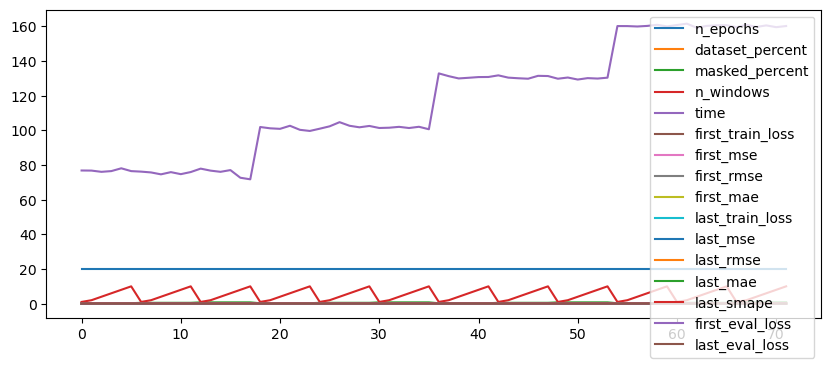

In [39]:
results_small.plot(figsize = (10,4))

<Axes: >

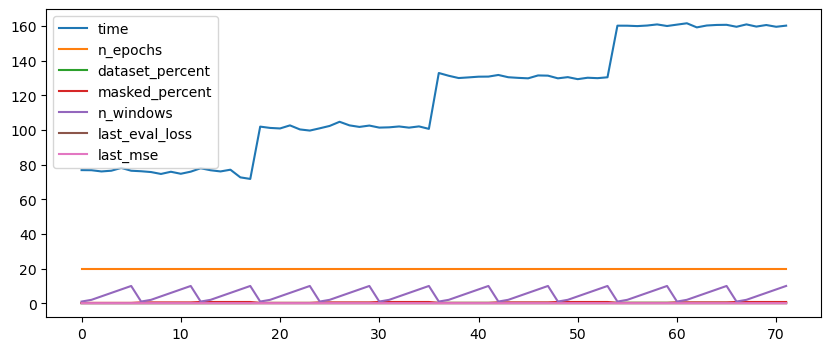

In [40]:
df_time_analysis_small = results_small[[
    "time", 
    "n_epochs", 
    "dataset_percent", 
    "masked_percent", 
    "n_windows", 
    "last_eval_loss", 
    "last_mse"
]]
df_time_analysis_small.plot(figsize = (10,4))

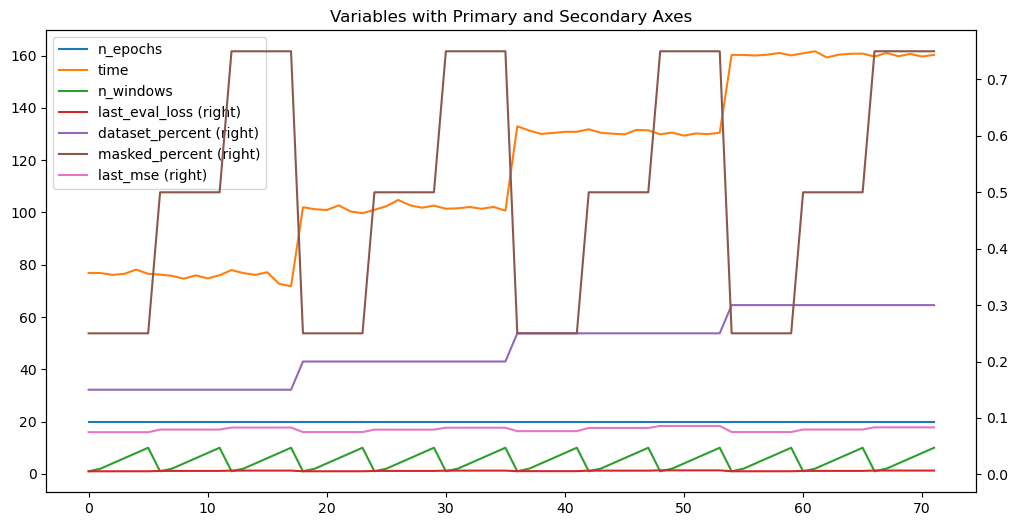

In [41]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time", "n_windows"], ["last_eval_loss", "dataset_percent", "masked_percent", 'last_mse'])

In [42]:
profile_small_df = df_time_analysis_small.copy(deep = True)

In [43]:
#profile_small.to_notebook_iframe()

In [44]:
profile_small_df.head()

time n_epochs  dataset_percent  masked_percent n_windows  \
0  76.874835       20             0.15            0.25         1   
1  76.818147       20             0.15            0.25         2   
2  76.101033       20             0.15            0.25         4   
3  76.527990       20             0.15            0.25         6   
4  78.141969       20             0.15            0.25         8   

   last_eval_loss  last_mse  
0         0.00542   0.07471  
1         0.00542   0.07471  
2         0.00542   0.07471  
3         0.00542   0.07471  
4         0.00542   0.07471

In [45]:
print(profile_small_df.dtypes)

time               float64
n_epochs            object
dataset_percent    float64
masked_percent     float64
n_windows           object
last_eval_loss     float64
last_mse           float64
dtype: object


In [46]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir masked_percent a float, manejando posibles errores
profile_small_df['masked_percent'] = pd.to_numeric(profile_small_df['masked_percent'], errors='coerce').astype(float)

In [47]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

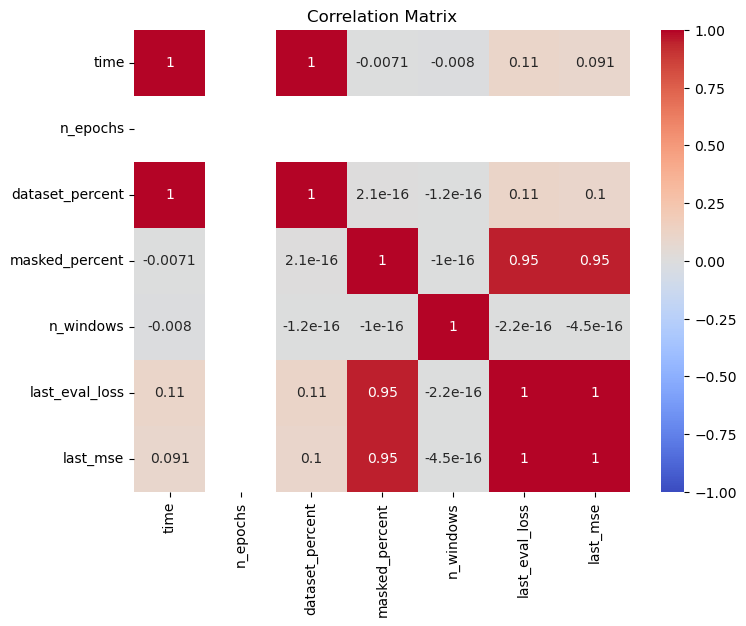

In [48]:
 plot_correlation(profile_small_df)

A nivel de tiempo, se observa que:

- Apenas afecta el enmascarado, con una correlación negativa con el last loss. Lo mismo ocurre con el n_epochs
- Más tiempo parece hacer crecer el last_loss
- Lo que más influye es el porcentaje de dataset utilizado para el fine_tuning. Más dataset parece hacer empeorar por alguna razón
- El last loss está bastante relacionado con el tiempo dedicado al fine-tuning, como es de esperar. Pero. La correlación es positiva => más last loss => más tiempo.
- El número de ventanas parece ir en contra de bajar el loss.. quizá porque va de la mano del número de ventanas.


### Loss & metrics analysis

A nivel de losses, se observa (sin tener en cuenta mse, rmse, mae, smape): 
- Muy poca relación con el enmascarado, cosa que de primeras sorprende
- Mucha relación con el % de dataset utilizado en el fine-tuning
Por lo tanto,
    - vamos a filtrar el dataset para tener tiempos menores a 8 segundos
y buenos losses.
    - Veamos a partir de qué momento se obtienen unos losses razonables  en %.

In [49]:
results_small.columns

Index(['model_size', 'n_epochs', 'dataset_percent', 'masked_percent',
       'n_windows', 'time', 'first_train_loss', 'first_mse', 'first_rmse',
       'first_mae', 'first_smape', 'last_train_loss', 'last_mse', 'last_rmse',
       'last_mae', 'last_smape', 'windows', 'best_epochs', 'train_losses',
       'eval_pre', 'eval_post', 'full_result', 'first_eval_loss',
       'last_eval_loss'],
      dtype='object')

In [50]:
df_loss_small = results_small[[
    "time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", 
    "first_eval_loss", "last_eval_loss", "first_mse", "last_mse"
]].copy()

In [51]:
display(df_loss_small[["first_eval_loss", "last_eval_loss"]])
display(df_loss_small[["first_mse", "last_mse"]])

first_eval_loss  last_eval_loss
0          0.006965        0.005420
1          0.006964        0.005420
2          0.006964        0.005420
3          0.006964        0.005420
4          0.006964        0.005420
..              ...             ...
67         0.007721        0.006683
68         0.007721        0.006683
69         0.007721        0.006683
70         0.007721        0.006683
71         0.007721        0.006683

[72 rows x 2 columns]

first_mse  last_mse
0    0.084806  0.074710
1    0.084791  0.074710
2    0.084791  0.074710
3    0.084791  0.074710
4    0.084791  0.074710
..        ...       ...
67   0.089605  0.083316
68   0.089605  0.083316
69   0.089605  0.083316
70   0.089605  0.083316
71   0.089605  0.083316

[72 rows x 2 columns]

<Axes: >

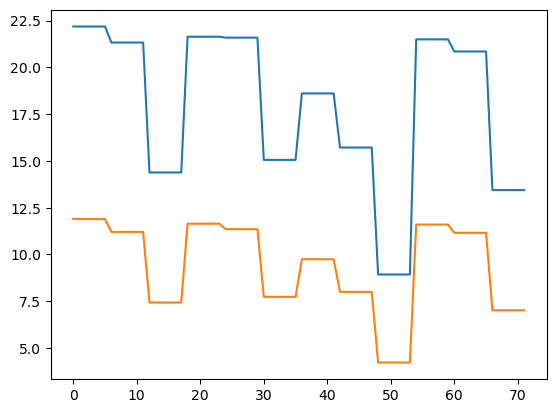

In [52]:
df_loss_small["loss_percent"] = (df_loss_small['first_eval_loss']-df_loss_small['last_eval_loss'])*100/(df_loss_small['first_eval_loss'])
df_loss_small["loss_percent"].plot()
df_loss_small["mse_percent"] = (df_loss_small['first_mse']-df_loss_small['last_mse'])*100/(df_loss_small['first_mse'])
df_loss_small["mse_percent"].plot()

In [53]:
df_loss_small[df_loss_small["loss_percent"] > 0]

time n_epochs  dataset_percent  masked_percent n_windows  \
0    76.874835       20             0.15            0.25         1   
1    76.818147       20             0.15            0.25         2   
2    76.101033       20             0.15            0.25         4   
3    76.527990       20             0.15            0.25         6   
4    78.141969       20             0.15            0.25         8   
..         ...      ...              ...             ...       ...   
67  160.986255       20             0.30            0.75         2   
68  159.726212       20             0.30            0.75         4   
69  160.621295       20             0.30            0.75         6   
70  159.611959       20             0.30            0.75         8   
71  160.267277       20             0.30            0.75        10   

    first_eval_loss  last_eval_loss  first_mse  last_mse  loss_percent  \
0          0.006965        0.005420   0.084806  0.074710     22.182949   
1          0.006964        0.005420   0.084791  0.074710     22.180974   
2          0.006964        0.005420   0.084791  0.074710     22.180974   
3          0.006964        0.005420   0.084791  0.074710     22.180974   
4          0.006964        0.005420   0.084791  0.074710     22.180974   
..              ...             ...        ...       ...           ...   
67         0.007721        0.006683   0.089605  0.083316     13.441368   
68         0.007721        0.006683   0.089605  0.083316     13.441368   
69         0.007721        0.006683   0.089605  0.083316     13.441368   
70         0.007721        0.006683   0.089605  0.083316     13.441368   
71         0.007721        0.006683   0.089605  0.083316     13.441368   

    mse_percent  
0     11.905252  
1     11.889622  
2     11.889622  
3     11.889622  
4     11.889622  
..          ...  
67     7.018892  
68     7.018892  
69     7.018892  
70     7.018892  
71     7.018892  

[72 rows x 11 columns]

<Axes: >

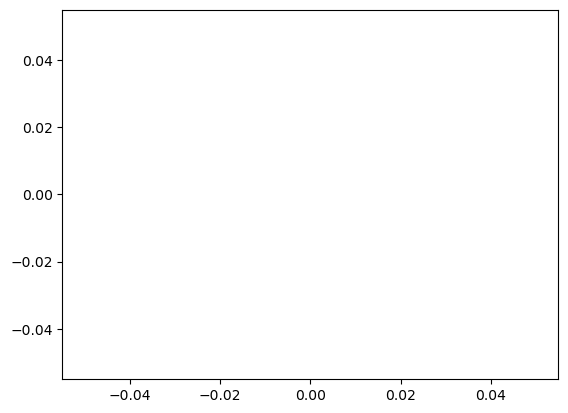

In [54]:
df_loss_small[df_loss_small["time"] < 8]["loss_percent"].plot()
df_loss_small[df_loss_small["time"] < 8]["mse_percent"].plot()

In [55]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_small_best_cases = df_loss_small[df_loss_small["time"] < 8].copy()

print("--------------------- Train -----------------")
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
print("---------------------- Eval ------------------")
# Filtrar los 5 mejores loss_percents
display(df_loss_small_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_small_best_cases[df_loss_small_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])

--------------------- Train -----------------


Empty DataFrame
Columns: [time, n_epochs, dataset_percent, masked_percent, n_windows, first_eval_loss, last_eval_loss, first_mse, last_mse, loss_percent, mse_percent]
Index: []

Empty DataFrame
Columns: [time, n_epochs, dataset_percent, masked_percent, n_windows, first_eval_loss, last_eval_loss, first_mse, last_mse, loss_percent, mse_percent]
Index: []

---------------------- Eval ------------------


Empty DataFrame
Columns: [time, n_epochs, dataset_percent, masked_percent, n_windows, first_eval_loss, last_eval_loss, first_mse, last_mse, loss_percent, mse_percent]
Index: []

Empty DataFrame
Columns: [time, n_epochs, dataset_percent, masked_percent, n_windows, first_eval_loss, last_eval_loss, first_mse, last_mse, loss_percent, mse_percent]
Index: []

In [56]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df = df_loss_small[['time', 'n_epochs', 'dataset_percent', 'masked_percent', 'n_windows', 'loss_train_percent', 'mse_percent']].copy()
profile_small_df.dtypes

KeyError: "['loss_train_percent'] not in index"

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')
# Convertir masked_percent a float, manejando posibles errores
profile_small_df['masked_percent'] = pd.to_numeric(profile_small_df['masked_percent'], errors='coerce').astype(float)

In [ ]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_loss_small'", explorative=True)
plot_correlation(profile_small_df)

#### What if I focus on 0.25 dataset percent?

In [ ]:
profile_small_df_2 = df_time_analysis_small[df_time_analysis_small['dataset_percent'] == 0.25].drop(columns=['dataset_percent', 'time']).copy()

In [ ]:
profile_small_df_2.dtypes

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df_2['n_epochs'] = pd.to_numeric(profile_small_df_2['n_epochs'], errors='coerce').astype('Int64')
profile_small_df_2['n_windows'] = pd.to_numeric(profile_small_df_2['n_windows'], errors='coerce').astype('Int64')
# Convertir masked_percent a float, manejando posibles errores
profile_small_df_2['masked_percent'] = pd.to_numeric(profile_small_df_2['masked_percent'], errors='coerce').astype(float)

In [ ]:
profile_small_2 = ydp.ProfileReport(profile_small_df_2, title="Pandas Profiling Report for 'df_time_analysis_small' for < 0.25 dataset percent", explorative=True)
plot_correlation(profile_small_df_2)

* Correlación inversa entre masked percent y last loss * => Aumentar masked percent baja last_loss
* => Es parte de lo que queremos!

In [ ]:
#! ls errors*

In [ ]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

## Moment-base

### Download the model

In [ ]:
print("Getting base artifact: ", enc_artifact_base_name)
enc_artifact_base  = wandb_api.artifact(enc_artifact_base_name, type='learner')
moment_base  = enc_artifact_base.to_obj()

### Select parameters

In [ ]:
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")
n_epochs_list_base= [5, 10, 20]
dataset_percents_base  = [0.25, 0.5]
masked_percents_base = [ 0.25, 0.5, 0.75]
sizes_base             = [1, 5, 10]
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(masked_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

### Configure files and wether already computed or not

In [ ]:
already_computed_base = True
results_base = None
errors_base = None
file_errors_base = 'errors_base_24012025_1.csv'
file_results_base = 'results_base_24012025_1.csv'

### Execute cases

In [ ]:
results_base = None
errors_base = None
if already_computed_base:
    results_base = pd.read_csv(file_results_base, index_col=None, header=0)
    errors_base = pd.read_csv(file_errors_base, index_col=None, header=0)
else:
    results_base, errors_base = cases_loop(
        model             = moment_base, 
        n_epochs_list     = n_epochs_list_base, 
        dataset_percents  = dataset_percents_base, 
        masked_percents = masked_percents_base,
        n_sizes_list      = sizes_base, 
        summarized        = True,
        verbose           = 8
    )
    results_base.to_csv(file_results_base, index=False, header=True)
    errors_base.to_csv(file_errors_base, index=False, header=True)
    already_computed_base = True

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_base)}")
display(errors_base.head())
print(f"Total results: {len(results_base)}")
display(results_base.head())

### Checking the errors

In [ ]:
len(results_base)

In [ ]:
error_base_window_sizes = list(errors_base['windows'].drop_duplicates())
error_base_window_sizes

In [ ]:
error_base_mssg = errors_base['error'].astype(str).drop_duplicates()
error_base_mssg

In [ ]:
base_windows = results_base['windows'].drop_duplicates()
filtered_windows_base = base_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
filtered_windows_base

#### Time analysis

In [ ]:
df_time_analysis_base = results_base[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "last_train_loss", "last_mse"]]

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_base, ["n_epochs", "time", "n_windows"], ["last_train_loss", "dataset_percent", "masked_percent", "last_mse"])

In [ ]:
profile_base_df = df_time_analysis_base.copy(deep = True)
profile_base = ydp.ProfileReport(profile_base_df, title="Pandas Profiling Report for 'df_time_analysis_base'", explorative=True)

In [ ]:
plot_correlation(profile_base_df)

#### Loss & metrics analysis

In [ ]:
df_loss_base = results_base[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()
df_loss_base["loss_percent"] = (df_loss_base['first_train_loss']-df_loss_base['first_train_loss'])*100/(df_loss_base['first_train_loss'])
df_loss_base["loss_percent"].plot()
df_loss_base["mse_percent"] = (df_loss_base['first_mse']-df_loss_base['last_mse'])*100/(df_loss_base['first_mse'])
df_loss_base["mse_percent"].plot()

In [ ]:
df_loss_base[df_loss_base["time"] < 8]["loss_percent"].plot()
df_loss_base[df_loss_base["time"] < 8]["mse_percent"].plot()

In [ ]:
df_loss_base[df_loss_base["time"] < 20]

In [ ]:
# Filtrar filas donde "time" es menor a 8 segundos
df_loss_base_best_cases = df_loss_base[df_loss_base["time"] < 8].copy()

print("---- Mejoras en el entrenamiento ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('loss_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('loss_percent', ascending = False)[:5])
print("---- Mejoras en la validación  ----")
# Filtrar los 5 mejores loss_percents
display(df_loss_base_best_cases.sort_values('mse_percent', ascending = False)[:5])
# Filtrar los 5 mejores loss_percent con dataset percent <= 0.25
display(df_loss_base_best_cases[df_loss_base_best_cases['dataset_percent'] < 0.50].sort_values('mse_percent', ascending = False)[:5])

In [ ]:
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

## Moment-large

### Download de large model

In [ ]:
already_computed_large = True
file_errors_large = 'errors_large_03022025_1.csv'
file_results_large = 'results_large_03022025_1.csv'

In [ ]:
if not already_computed_large:
    print("Getting large artifact: ", enc_artifact_large_name)
    enc_artifact_large = wandb_api.artifact(enc_artifact_large_name, type='learner')
    print(enc_artifact_large.name)
    moment_large = enc_artifact_large.to_obj()
    print(count_parameters(moment_large))

In [ ]:
total_cases_small      = len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)
print(f"Total cases: {total_cases_small}")
total_cases_base = len(n_epochs_list_base)*len(dataset_percents_base)*len(masked_percents_base)*len(sizes)
print(f"Total cases: {total_cases_base}")
expected_time = total_time*total_cases_base/total_cases_small
print(f"Expected time: {expected_time} seconds | {expected_time/60} minutes | {expected_time/60/60} hours")

n_epochs_list_large     = [5, 10, 20]
dataset_percents_large  = [0.25, 0.5] # No tendría sentido porque sería como hacer lo mismo que con mvp
masked_percents_large = [0.25, 0.5, 0.75]
sizes_large             = [1, 5, 10]
print(f"Total cases: {len(n_epochs_list)*len(dataset_percents)*len(masked_percents)*len(sizes)}")

In [ ]:
torch.cuda.memory_allocated()
torch.cuda.set_device(1)
torch.cuda.current_device()

In [ ]:
results_large = None
errors_large = None
if already_computed_large:
    results_large = pd.read_csv(file_results_large, index_col=None, header=0)
    errors_large = pd.read_csv(file_errors_large, index_col=None, header=0)
else:
    results_large, errors_large = cases_loop(
        model             = moment_large, 
        n_epochs_list     = n_epochs_list_large,
        dataset_percents  = dataset_percents_large, 
        masked_percents = masked_percents_large, 
        n_sizes_list      = sizes_large, 
        summarized        = True,
        save              = True,
        file_errors       =  file_errors_large,
        file_results      = file_results_large
    )
    already_computed_large = True

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())
print("------------------")

In [ ]:
print("----- ERRORS -----")
print(f"Total error cases: {len(errors_large)}")
display(errors_large.head())
print(f"Total results: {len(results_large)}")
display(results_large.head())

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_large.to('cpu')
for param in moment_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
gc.collect()
print("Mejorado: ", after-before)

#### Errors analysis

In [ ]:
if len(errors_large) > 0:
    error_large_window_sizes = list(errors_large['window'].drop_duplicates())
    error_large_window_sizes

In [ ]:
try:
    error_large_mssg = errors_large['error'].astype(str).drop_duplcates()
    display(error_large_mssg)
except Exception as e:
    print(e)

In [ ]:
large_windows = results_large['windows'].drop_duplicates()
print(large_windows.shape)
display(large_windows)

In [ ]:
filtered_windows_large = large_windows.apply(lambda x: greater_than(x, 5)).apply(sorted)
display(filtered_windows_large)

#### Time analysis

In [ ]:
df_time_analysis_large = results_large[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "last_train_loss", 'last_mse']]
df_time_analysis_large.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_large, ["n_epochs", "time", "n_windows"], ["last_train_loss", 'last_mse', "dataset_percent", "masked_percent"])

In [ ]:
profile_large_df = df_time_analysis_large.copy(deep = True)
profile_large = ydp.ProfileReport(profile_large_df, title = "Pandas Profiling Report for 'df_time_analysis_large'", explorative = True)
#profile_large.to_notebook_iframe()

In [ ]:
plot_correlation(profile_large_df)

In [ ]:
df_loss_large = results_large[["time", "n_epochs", "dataset_percent", "masked_percent", "n_windows", "first_train_loss", "last_train_loss", "first_mse", "last_mse"]].copy()

In [ ]:
df_loss_large["loss_train_percent"] = (df_loss_large['first_train_loss']-df_loss_large['last_train_loss'])*100/(df_loss_large['first_train_loss'])
df_loss_large["mse_percent"] = (df_loss_large['first_mse']-df_loss_large['last_mse'])*100/(df_loss_large['first_mse'])
df_loss_large["loss_train_percent"].plot()
df_loss_large["mse_percent"].plot()

In [ ]:
df_loss_large_best_cases = df_loss_large[df_loss_large["time"] < 8].copy()
display(df_loss_large_best_cases)
print("--- train ---")
display(df_loss_large_best_cases[df_loss_large_best_cases["loss_train_percent"] > 0])
print("--- eval ---")
display(df_loss_large_best_cases[df_loss_large_best_cases["mse_percent"] > 0])
display(df_loss_large_best_cases)

In [ ]:
display(df_loss_large_best_cases.sort_values('loss_train_percent', ascending = False))

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
gc.collect()
torch.cuda.empty_cache()
after = torch.cuda.memory_allocated()
print(after)
print(after-before)

In [ ]:
gpu_tensors = []
for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            gpu_tensors.append(obj)
    except ReferenceError:
        continue # Omitir los objetos que ya han sido recolectados
print(len(gpu_tensors))

#### Loss & metrics analysis

In [ ]:
#| export
if verbose > 0: print("Execution ended")
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

In [ ]:
#| hide
if reset_kernel:
    os._exit(00)

# Memory checks

In [ ]:
snapshot = torch.cuda.memory_snapshot()
gpu_tensors = [obj['tensor'] for obj in snapshot if 'tensor' in obj]
for tensor_info in gpu_tensors:
    print(f"Size: {tensor_info['size']}, Device: {tensor_info['device']}, Data type: {tensor_info['dtype']}")
print(gpu_tensors)

In [ ]:
object_types = set()
for obj in snapshot:
    for key in obj.keys():
        object_types.add(key)
print("Tipos de objetos encontrados en el snapshot:")
for obj_type in sorted(object_types):
    print(obj_type)
heavier_obj = None
for obj in snapshot:
    if heavier_obj is None or obj['total_size'] > heavier_obj['total_size']: heavier_obj = obj
print(heavier_obj)

In [ ]:
before = torch.cuda.memory_allocated()
print(torch.cuda.memory_allocated())
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_small.to('cpu')
for param in moment_small.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_base.to('cpu')
for param in moment_base.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
before = torch.cuda.memory_allocated()
print(before)
moment_large.to('cpu')
for param in moment_large.parameters():
    param.to('cpu')
after = torch.cuda.memory_allocated()
print(after)
print("Mejorado: ", after-before)

In [ ]:
error_small_window_sizes = list(errors_small_hoy['windows'].drop_duplicates())
error_small_window_sizes

In [ ]:
errors_small_hoy

In [ ]:
total_time = results_small_hoy['time'].sum()
print(f"{total_time} seconds")
print(f"{total_time/60} minutes")
print(f"{total_time/60/60} hours")

In [ ]:
df_time_analysis_small = results_small_hoy[["time", "n_epochs", "dataset_percent", "masked_percent", "last_train_loss", 'last_mse']]
df_time_analysis_small.plot(figsize = (10,4))

In [ ]:
plot_with_multiple_secondary_y(df_time_analysis_small, ["n_epochs", "time"], ["last_train_loss", "dataset_percent", "masked_percent", 'last_mse'])

In [ ]:
profile_small_df = df_time_analysis_small.copy(deep = True)

In [ ]:
print("--- Cases ---")
print("--- Number of epochs ---")
print(profile_small_df["n_epochs"].unique())
print("--- Dataset percent ---")
print(profile_small_df["dataset_percent"].unique())
print("--- Dataset masked percent ---")
print(profile_small_df["masked_percent"].unique())

In [ ]:
profile_small_df.head()

In [ ]:
print(profile_small_df.dtypes)

In [ ]:
# Convertir n_epochs y n_windows a enteros, manejando posibles errores
profile_small_df['n_epochs'] = pd.to_numeric(profile_small_df['n_epochs'], errors='coerce').astype('Int64')
#profile_small_df['n_windows'] = pd.to_numeric(profile_small_df['n_windows'], errors='coerce').astype('Int64')

# Convertir masked_percent a float, manejando posibles errores
profile_small_df['masked_percent'] = pd.to_numeric(profile_small_df['masked_percent'], errors='coerce').astype(float)

In [ ]:
profile_small = ydp.ProfileReport(profile_small_df, title="Pandas Profiling Report for 'df_time_analysis_small'", explorative=True)

In [ ]:
 plot_correlation(profile_small_df)